In [1]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
sys.path.append('./../src/')
import dill
# dill.load_session(f'base.db')
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import networkx as nx
import matplotlib.pyplot as plt

import utils
import pickle

from itertools import chain
import random
import numpy as np
from utils import id_to_name, name_to_id

random.seed(9)
np.random.seed(9)

date = "sep2024"
atleast = 2
with open(f"uberon_{date}_atleast{atleast}", "rb") as dill_file:
    subtree, subtree_meta, pos = dill.load(dill_file)
mlb=MultiLabelBinarizer().fit([[id_to_name[node] for node in subtree.nodes]])

# predict

In [2]:
filename = f"./../data/GEO/preprocessed/450K_Mvalues"
print(f"loading from {filename}...")
with open(filename, "rb") as dill_file:
    normal_Mv, normal_meta, island = pickle.load(dill_file)

loading from ./../data/GEO/preprocessed/450K_Mvalues...


In [3]:
avoid = ['tissue','mucosa', 'appendage']

normal_meta = normal_meta[~normal_meta['tissue_name'].isin(avoid)]
normal_Mv = normal_Mv.loc[normal_meta.index]

In [4]:
normal_meta.shape

(3182, 7)

In [5]:
len(normal_meta.series.unique())

124

In [6]:
len(normal_meta.tissue_name.unique())

69

In [7]:
filename = f"./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise"
print(f"loading from {filename}...")
with open(filename, "rb") as dill_file:
    mult_Mv, mult_meta, mult_island = pickle.load(dill_file)

loading from ./../data/GEO/preprocessed/450K_Mvalues_atleast2_samplewise...


In [8]:
import pandas as pd 

In [9]:
single_Mv = normal_Mv.loc[normal_Mv.index.difference(mult_Mv.index)][mult_Mv.columns]
single_meta = normal_meta.loc[single_Mv.index]

print(single_Mv.shape)
print(single_meta.shape)

# remove overlapping tissue names that passed through because originally removed due to n<4 samples
single_meta = single_meta[~single_meta['tissue_name'].isin(list(set(single_meta['tissue_name']) & set(mult_meta['tissue_name'])))]
single_Mv = single_Mv.loc[single_meta.index]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(single_Mv.transpose().values)
single_Mv_scaled = scaler.transform(single_Mv.transpose().values)
single_Mv_scaled = pd.DataFrame(single_Mv_scaled.transpose(), index=single_Mv.index, columns=single_Mv.columns)

print(single_Mv_scaled.shape)
print(single_meta.shape)

(578, 473821)
(578, 7)
(566, 473821)
(566, 7)


In [10]:
save_single = False

if save_single:
    with open(f"single", "wb") as dill_file:
        dill.dump([single_Mv_scaled, single_meta], dill_file)

In [11]:
meta_multi = utils.propagate_parent(subtree, mult_meta, outdict=False)
meta_mlb = mlb.transform(meta_multi['tissue_name'].values)

filename = "_whole"
minipatch_location = f"./../data/GEO/minipatch/minipatch{filename}_selector"
print(f"loading minipatch selector from {minipatch_location}")
fitted_selector = dill.load(open(minipatch_location, 'rb'))

selection_frequency_threshold = 0.57
selection_freq = pd.DataFrame(fitted_selector.Pi_hat_last_k_, index=mult_Mv.columns)
minipatch_probes = list(selection_freq[selection_freq[0]>=selection_frequency_threshold].index)
Mv = mult_Mv[minipatch_probes]

with open(f"./../data/GEO/minipatch/multilabel{filename}_clf", 'rb') as f:
    clf = pickle.load(f)

tissue_to_clf = {t:c for t,c in zip(mlb.classes_, clf.estimators_)}

loading minipatch selector from ./../data/GEO/minipatch/minipatch_whole_selector


In [12]:
# import pickle
# # Save dictionary to a pickle file
# with open('minipatch_probes_meta_multi_mlb.pkl', 'wb') as file:
#     pickle.dump([minipatch_probes, meta_multi, mlb], file)

In [13]:
avoid = ['tissue','mucosa', "appendage"]

single_Mv_minipatch = single_Mv_scaled[Mv.columns]

single_meta = single_meta[~single_meta['tissue_name'].isin(avoid)]
print(single_meta.shape)
single_Mv_minipatch = single_Mv_minipatch.loc[single_meta.index]

(566, 7)


In [14]:
print(len(single_meta.tissue_name.unique()))
print(len(single_meta.series.unique()))

49
39


In [15]:
print(len(mult_meta.tissue_name.unique()))
print(len(mult_meta.series.unique()))

20
87


In [18]:
len(single_meta.tissue_name.unique()) + len(mult_meta.tissue_name.unique())
single_meta.shape[0] + mult_meta.shape[0]


3170

In [19]:
len(subtree)

24

In [14]:
pred = clf.predict(single_Mv_minipatch)

In [15]:
pred_proba_list = clf.predict_proba(single_Mv_minipatch)
pred_proba_df = pd.DataFrame(index=single_meta.index, columns=mlb.classes_)
for i, tissue in enumerate(mlb.classes_):
    pred_proba_df[tissue] = pred_proba_list[i][:,1]
pred_proba_df

,blood,breast,embryonic stem cell,exocrine gland,fibroblast,islet of Langerhans,leukocyte,liver,lymphocyte,monocyte,...,pancreas,peripheral blood mononuclear cell,placenta,prostate epithelium,reproductive structure,saliva,simple columnar epithelium,sperm,umbilical cord blood,visceral fat
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1484233,1.007549e-04,0.029226,0.000827,0.000585,0.000271,0.003169,1.000000e-07,0.000049,6.442251e-04,0.000004,...,0.002588,3.778761e-03,0.002325,0.000097,0.001806,0.000008,0.000159,0.000326,1.955302e-05,0.006331
GSM1484235,1.188029e-03,0.129030,0.000799,0.000709,0.000293,0.000235,1.000000e-07,0.000034,1.105576e-04,0.000005,...,0.005736,7.428874e-04,0.001250,0.000022,0.000299,0.000004,0.000034,0.000312,5.659187e-05,0.004171
GSM1484237,4.129988e-05,0.099537,0.000642,0.001014,0.000342,0.000158,1.000000e-07,0.000045,1.584112e-04,0.000004,...,0.006200,1.286715e-03,0.001448,0.000167,0.001582,0.000013,0.000093,0.000291,8.386523e-06,0.010573
GSM1484239,8.222504e-05,0.020243,0.000737,0.001400,0.000319,0.000428,1.000000e-07,0.000039,1.122905e-04,0.000005,...,0.006763,7.176085e-03,0.001186,0.000157,0.001710,0.000010,0.000111,0.000261,9.709385e-06,0.005496
GSM1484241,4.299742e-04,0.099908,0.000734,0.000891,0.000183,0.000178,1.000000e-07,0.000044,3.323891e-04,0.000005,...,0.006518,2.308792e-03,0.001703,0.000061,0.000824,0.000003,0.000083,0.000318,8.590463e-06,0.004648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5384604,9.093618e-04,0.011935,0.000748,0.071320,0.000167,0.000019,3.072098e-03,0.000752,2.888102e-07,0.000020,...,0.055153,2.544081e-06,0.000502,0.000020,0.000027,0.000883,0.000926,0.000280,1.000000e-07,0.000049
GSM5384608,3.346807e-07,0.036446,0.000895,0.009102,0.000805,0.000086,1.000000e-07,0.000105,1.718984e-05,0.000002,...,0.026701,1.000000e-07,0.000453,0.000655,0.000836,0.000007,0.871141,0.000362,1.000000e-07,0.000029
GSM5384610,1.000000e-07,0.093342,0.001471,0.000884,0.000491,0.038008,6.446301e-07,0.000034,1.000000e-07,0.000003,...,0.003611,1.000000e-07,0.000493,0.000056,0.000075,0.038671,0.002811,0.000513,1.000000e-07,0.000034


In [16]:
def top_columns(row, top_n):
    top_values = row.nlargest(top_n)
    return top_values.index.tolist()

In [17]:
true = single_meta['tissue_name']

In [18]:
pred_name = pd.Series(mlb.inverse_transform(pred), index=single_meta.index)

In [19]:
def print_highest_counter_elements(elements):
    counter = Counter(elements)
    max_count = max(counter.values())
    highest_elements = [element for element, count in counter.items() if count == max_count]
    return f"{', '.join(map(str, highest_elements))}"

def highest_counter_elements(elements):
    counter = Counter(elements)
    max_count = max(counter.values())
    highest_elements = [element for element, count in counter.items() if count == max_count]
    return highest_elements

In [20]:
save_preds = False

if save_preds:
    with open(f"zeroshot_preds", "wb") as dill_file:
        dill.dump([pred_proba_df, single_meta],dill_file)

In [21]:
from collections import Counter

In [22]:
pred_meta = single_meta.copy(deep=True)

preds = dict()
for tissue in np.unique(true.values):
    tissue_preds = pred_name.loc[single_meta[single_meta['tissue_name']==tissue].index].values
    tissue_preds = list(chain.from_iterable(tissue_preds))
    
    if len(tissue_preds)==0: #eliminate those with no predictions: TODO for what to do with them
        print(f"{tissue}: NO PREDICTION")
        pred_meta = pred_meta[pred_meta['tissue_name']!=tissue]
        pred_pred = pred_name.loc[pred_meta.index]
    else:
        preds[tissue] = highest_counter_elements(tissue_preds)
        print(f"{tissue}: {print_highest_counter_elements(tissue_preds)}")

adipose tissue: breast
aorta smooth muscle tissue: fibroblast
ascending aorta: NO PREDICTION
bone marrow: myoblast
brain: exocrine gland
bronchus: nasal cavity epithelium, simple columnar epithelium
cartilage tissue: NO PREDICTION
cervix squamous epithelium: saliva
chorionic villus: placenta, reproductive structure
colon: exocrine gland, pancreas
cornea: NO PREDICTION
corpus callosum: NO PREDICTION
diaphragm: NO PREDICTION
duodenum: exocrine gland, pancreas
endothelial cell: blood
esophagus: NO PREDICTION
esophagus squamous epithelium: saliva
fallopian tube: simple columnar epithelium, blood, visceral fat
frontal lobe: NO PREDICTION
gastric gland: exocrine gland, pancreas
granulocyte: blood, umbilical cord blood
intestinal mucosa: exocrine gland
intestine: exocrine gland
kidney: NO PREDICTION
larynx: breast, nasal cavity epithelium, simple columnar epithelium
left cardiac atrium: NO PREDICTION
lung: exocrine gland
macrophage: blood, leukocyte, monocyte, myeloid leukocyte, peripheral bl

In [23]:
def check_graph(g):
    if isinstance(g, nx.MultiDiGraph):
        print(f"directed acyclic graph: {nx.is_directed_acyclic_graph(g)}")
        print(f"weakly connected: {nx.is_weakly_connected(g)}")
        print(f"strongly connected: {nx.is_strongly_connected(g)}")
        print(f"weakly connected components: {[len(c) for c in nx.weakly_connected_components(g)]}")
    else:
        print(f"connected: {nx.is_connected(g)}")
        print(f"components: {[len(c) for c in nx.connected_components(g)]}")

### set up ontology

In [ ]:
def reroute(tree, from_node, to_node):
    tree_copy=copy.deepcopy(tree)
    # print(f'from: {from_node}')
    # print(f'to: {to_node}')
    # print("in:")
    for e in tree.in_edges(from_node):
        if e[0]!=to_node: tree_copy.add_edge(e[0], to_node, list(tree.get_edge_data(e[0],e[1]).keys())[0])
        tree_copy.remove_edge(e[0],e[1])
        # print(e)
        # print(e[0], to_node)
    # print("out:")
    for e in tree.out_edges(from_node):
        if e[1]!=to_node: tree_copy.add_edge(to_node, e[1], list(tree.get_edge_data(e[0],e[1]).keys())[0])
        tree_copy.remove_edge(e[0],e[1])
        # print(e)
        # print(to_node, e[1])
    print(f'{from_node} is isolate: {nx.is_isolate(tree_copy, from_node)}')
    tree_copy.remove_node(from_node)
    return tree_copy

def filter_edge(n1, n2, edgekey):
    return edgekey in ['is_a', 'part_of']

def collapse(tree, root, tissues):
    tree_copy=copy.deepcopy(tree)
    tree_copy=nx.MultiDiGraph(tree_copy)
    
    pos=graphviz_layout(tree, prog='dot', root=name_to_id[root])
    pos={k:v for k, v in sorted(pos.items(), key=lambda item: item[1][1])}

    for node in pos.keys():
        if name_to_id['anatomical system'] in tree.successors(node) and id_to_name[node].split()[-1]=='system': continue
        if id_to_name[node] not in tissues:
            parents=list(tree_copy.successors(node))
            children=list(tree_copy.predecessors(node))
            if len(parents)==1 and len(children)==1:
                tree_copy.add_edge(children[0], parents[0], list(tree_copy.get_edge_data(node, parents[0]).keys())[0])
                tree_copy.remove_node(node)
    return tree_copy

def cut_collapse(tree, meta_tissues, wanted, unwanted, display=True):
    cut_tree=tree.subgraph([x for x in tree.nodes() if x not in unwanted])
    cut_tree=nx.MultiDiGraph(collapse(cut_tree, root, [id_to_name[x] for x in wanted]))

    keep_comp=list()
    for comp in nx.weakly_connected_components(cut_tree):
        if len(comp.intersection(set(wanted)))==1: keep_comp.extend(list(comp.intersection(set(wanted))))
        elif any(n in wanted for n in list(comp)): keep_comp.extend(list(comp))
    cut_tree=nx.MultiDiGraph(cut_tree.subgraph([x for x in cut_tree.nodes() if x in keep_comp]))
    
    cut_pos=graphviz_layout(cut_tree, prog='dot', root=name_to_id[root])
    for key in cut_pos.keys():
        x,y=cut_pos[key]
        cut_pos[key]=(x,-y)
    cut_label=dict((k, label_dict[k]) for k in list(cut_tree.nodes()) if k in label_dict)

    meta_node=[name_to_id[x] for x in meta_tissues if name_to_id[x] in cut_pos.keys()]
    noninformative=[n for n in cut_tree.nodes() 
                    if 'subset' in cut_tree.nodes[n] and ('non_informative' in cut_tree.nodes[n]['subset']
                    or 'upper_level' in cut_tree.nodes[n]['subset'])]
    rest_node=[x for x in set(cut_tree.nodes)-set(meta_node)-set(noninformative)]

    if display:
        plt.figure(dpi=300)
        node_size=200
        font_size=3
        nx.draw(cut_tree, cut_pos, nodelist=meta_node, node_color='#00bfff', labels=cut_label, with_labels=True, arrows=False,
                font_size=font_size, node_size=node_size) # BLUE
        nx.draw(cut_tree, cut_pos, nodelist=noninformative, node_color='#90EE90', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREEN
        nx.draw(cut_tree, cut_pos, nodelist=rest_node, node_color='#abc2c1', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREY
        nx.draw_networkx_edges(
            cut_tree,
            cut_pos,
            edgelist=[e for e in cut_tree.edges() if 'is_a' in cut_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:red",
        arrows=False)
        nx.draw_networkx_edges(
            cut_tree,
            cut_pos,
            edgelist=[e for e in cut_tree.edges() if 'part_of' in cut_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:blue",
        arrows=False)
        
    return cut_tree

def remove_triangle(tree, display=True):
    copy_tree=copy.deepcopy(tree)
    
    adj=pd.DataFrame(nx.to_numpy_array(copy_tree), index= copy_tree.nodes(), columns=copy_tree.nodes())
    adj2=pd.DataFrame(np.matmul(adj, adj), index= copy_tree.nodes(), columns=copy_tree.nodes())

    for n in tree.nodes:
        children=adj[adj.loc[n]>0].index
        grandchildren=adj2[adj2.loc[n]>0].index
        triangle=children & grandchildren
        if len(triangle)>0:
            for x in triangle:
                copy_tree.remove_edge(n, x)
                print(f"removed edge between {id_to_name[n]} and {id_to_name[x]}")

    if display:
        cut_pos=graphviz_layout(copy_tree, prog='dot', root=name_to_id[root])
        for key in cut_pos.keys():
            x,y=cut_pos[key]
            cut_pos[key]=(x,-y)
        cut_label=dict((k, label_dict[k]) for k in list(copy_tree.nodes()) if k in label_dict)

        meta_node=[name_to_id[x] for x in mult_meta['tissue_name'] if name_to_id[x] in cut_pos.keys()]
        noninformative=[n for n in copy_tree.nodes() 
                        if 'subset' in copy_tree.nodes[n] and ('non_informative' in copy_tree.nodes[n]['subset']
                        or 'upper_level' in copy_tree.nodes[n]['subset'])]
        rest_node=[x for x in set(cut_tree.nodes)-set(meta_node)-set(noninformative)]
        
        #display final structure
        plt.figure(dpi=300)
        node_size=200
        font_size=3
        nx.draw(copy_tree, cut_pos, nodelist=meta_node, node_color='#00bfff', labels=cut_label, with_labels=True, arrows=False,
                font_size=font_size, node_size=node_size) # BLUE
        nx.draw(copy_tree, cut_pos, nodelist=noninformative, node_color='#90EE90', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREEN
        # nx.draw(cut_tree, cut_pos, nodelist=basic_node, node_color='#ffffe0', labels=cut_label, with_labels=True, arrows=False, 
        #         font_size=font_size, node_size=node_size) # YELLOW
        nx.draw(copy_tree, cut_pos, nodelist=rest_node, node_color='#abc2c1', labels=cut_label, with_labels=True, arrows=False, 
                font_size=font_size, node_size=node_size) # GREY
        nx.draw_networkx_edges(
            copy_tree,
            cut_pos,
            edgelist=[e for e in copy_tree.edges() if 'is_a' in copy_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:red",
        arrows=False)
        nx.draw_networkx_edges(
            copy_tree,
            cut_pos,
            edgelist=[e for e in copy_tree.edges() if 'part_of' in copy_tree.get_edge_data(e[0], e[1])],
            width=1,
            alpha=1,
            edge_color="tab:blue",
        arrows=False)
    return copy_tree

def collapse_same_children_same_parents(tree):
    nodelist=list(tree.nodes)
    samedict=dict()
    for i,node in enumerate(nodelist):
        wanted_children=set(list(nx.ancestors(tree,node)))
        wanted_parents=set(list(tree.successors(node)))
        samelist=list()
        if len(wanted_children)==0:
            continue
        for j in range(i+1, len(nodelist)):
            test_children=set(list(nx.ancestors(tree,nodelist[j])))
            test_parents=set(list(tree.successors(nodelist[j])))
            if wanted_children==test_children and wanted_parents==test_parents: 
                if nodelist[j] not in samelist: samelist+=[nodelist[j]]
        if len(samelist)>0: samedict[node]=samelist
    [tree.remove_nodes_from(v) for k,v in samedict.items()]
    return tree

def collapse_same_pos_same_neut(graph, meta):
    nodelist = list(graph.nodes)
    samedict = dict()
    for i,node in enumerate(nodelist):
        wanted_pos = get_positives(graph, node, meta)
        wanted_neut = get_neutrals(graph, node, meta)
        samelist=list()
        if len(wanted_neut)==0 and len(wanted_pos)==0:
            continue
        for j in range(i+1, len(nodelist)):
            test_node=nodelist[j]
            test_pos = get_positives(graph, test_node, meta)
            test_neut = get_neutrals(graph, test_node, meta)
            if wanted_pos==test_pos and wanted_neut==test_neut: 
                if test_node not in samelist: samelist+=[test_node]
        if len(samelist)>0 and id_to_name[node] not in meta: samedict[node]=samelist
    return samedict

In [ ]:
import obonet
import networkx as nx

uberon=obonet.read_obo('./../annotation/uberon_ext.obo')
#dictionary of names to id 
id_to_name = {id_:data.get('name') for id_, data in uberon.nodes(data=True)}
name_to_id = {data.get('name'):id_ for id_, data in uberon.nodes(data=True)}

In [ ]:
check_graph(uberon)

In [ ]:
### filter by edge type
filtered_uberon = nx.subgraph_view(uberon, filter_edge=filter_edge)
filtered_uberon=nx.MultiDiGraph(filtered_uberon)
filtered_uberon.remove_nodes_from(list(nx.isolates(filtered_uberon)))

In [ ]:
check_graph(filtered_uberon)

In [ ]:
import copy

In [ ]:
### reroute anatomical entity

print([x for x in id_to_name.keys() if id_to_name[x]=='anatomical entity'])

filtered_uberon=reroute(filtered_uberon, 'CARO:0000000', 'UBERON:0001062')
id_to_name.pop('CARO:0000000')

In [ ]:
### reroute pancreas

filtered_uberon=reroute(filtered_uberon, name_to_id['exocrine pancreas'], name_to_id['pancreas'])
filtered_uberon=reroute(filtered_uberon, name_to_id['endocrine pancreas'], name_to_id['pancreas'])

In [ ]:
### reroute blood

filtered_uberon.remove_edge(name_to_id['monocyte'], name_to_id['mononuclear cell'])
filtered_uberon.remove_edge(name_to_id['lymphocyte'], name_to_id['mononuclear cell'])
filtered_uberon.add_edge(name_to_id['leukocyte'], name_to_id['blood'], 'is_a')
filtered_uberon.add_edge(name_to_id['monocyte'], name_to_id['peripheral blood mononuclear cell'], 'is_a')
filtered_uberon.add_edge(name_to_id['lymphocyte'], name_to_id['peripheral blood mononuclear cell'], 'is_a')

In [ ]:
check_graph(filtered_uberon)

In [ ]:
filtered_uberon.edges(name_to_id['leukocyte'], utils.name_to_id['neutrophil'])

In [ ]:
root='anatomical entity'
subtree=utils.create_subtree_root(filtered_uberon, list(single_meta['tissue_name'].unique())+list(mult_meta['tissue_name'].unique()), root)
subtree=nx.MultiDiGraph(subtree)
subtree_meta=mult_meta[mult_meta['tissue_name'].isin([id_to_name[x] for x in subtree.nodes()])]

In [ ]:
check_graph(subtree)

In [ ]:
def node_with_attribute(g, k, v=None):
    if v:
        return [n for n, d in g.nodes(data=True) if k in d and v in d[k]]
    else:
        return [n for n, d in g.nodes(data=True) if k in d]

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

In [ ]:
tissues=mult_meta['tissue_name'].unique()
pos=graphviz_layout(subtree, prog='dot', root=name_to_id[root])
x_pos=[pos[name_to_id[x]][0] for x in tissues if name_to_id[x] in pos.keys()]
ordered=[tissues[x] for x in np.argsort(x_pos)]

for key in pos.keys():
    x,y=pos[key]
    pos[key]=(x,-y)
label_dict={key:id_to_name[key] for key in subtree.nodes()}
for key in label_dict.keys():
    if len(label_dict[key].split(" "))>4:
        label_dict[key]=" ".join(label_dict[key].split()[:3])+"\n..."
    label_dict[key]=label_dict[key].replace(" ", "\n")

meta_node=[name_to_id[x] for x in mult_meta['tissue_name'].unique() if name_to_id[x] in pos.keys()]
noninformative=[n for n in subtree.nodes() 
                if 'subset' in subtree.nodes[n] and ('non_informative' in subtree.nodes[n]['subset']
                or 'upper_level' in subtree.nodes[n]['subset']
                                                    )]
field = "property_value"
value = "curator_notes \"Grouping term for query purposes\" xsd:string"
query_node = node_with_attribute(subtree, field, value)
rest_node=[x for x in set(subtree.nodes)-set(meta_node)-set(noninformative)-set(query_node)]

plt.figure(dpi=300)
node_size=200
font_size=3

blue = '#00bfff'
orange = '#FFA500'
green = '#90EE90'
grey = '#abc2c1'

nx.draw(subtree, pos, nodelist=meta_node, node_color=orange, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # meta = ORANGE
nx.draw(subtree, pos, nodelist=noninformative, node_color=blue, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # noninformative/upper level = BLUE
nx.draw(subtree, pos, nodelist=query_node, node_color=green, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # query = GREEN
nx.draw(subtree, pos, nodelist=rest_node, node_color=grey, labels=label_dict, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # rest = GREY

print([len(c) for c in nx.weakly_connected_components(subtree)])
[print([id_to_name[s] for s in c]) for c in nx.weakly_connected_components(subtree) if len(c)<5]
None

In [ ]:
'ovary' in wanted_tissue

In [ ]:
### cut non-informative, upper level
### cut query

manual_exclude=['independent continuant','material entity','entity','anatomical collection', 'gland', 'anatomical conduit',
               'developing anatomical structure','midface','upper respiratory conduit','olfactory apparatus chamber',
               'structure with developmental contribution from neural crest','digestive system element','external soft tissue zone','extraembryonic structure',
               'object','root','conceptus','anterior region of body','tube','entire sense organ system','entire extraembryonic component', 
               "mucosa","sense organ","nose","face", 'appendage', 'limb']

wanted_tissue=list(single_meta['tissue_name'].unique())+list(mult_meta['tissue_name'].unique())
wanted_node=[name_to_id[x] for x in wanted_tissue]
unwanted_node=[x for x in subtree.nodes() if 'subset' in subtree.nodes[x].keys() 
               and ('non_informative' in subtree.nodes[x]['subset'] 
                    or 'upper_level' in subtree.nodes[x]['subset']
                   )]+[name_to_id[x] for x in manual_exclude]+query_node
# unwanted_node=[x for x in subtree.nodes() if 'subset' in subtree.nodes[x].keys() 
#                and ('non_informative' in subtree.nodes[x]['subset'] 
#                     or 'upper_level' in subtree.nodes[x]['subset']
#                    )]+query_node
cut_tree=cut_collapse(subtree, mult_meta['tissue_name'], wanted_node, unwanted_node)

check_graph(cut_tree)

In [ ]:
#get rid of it if 1 child + not wanted

unwanted_node=list()
for node in cut_tree.nodes:
    node_parents=list(cut_tree.successors(node))
    node_children=list(cut_tree.predecessors(node))
    if node in wanted_node: continue
    elif (len(node_children)==0): unwanted_node.extend([node])
    elif (len(node_parents)==0 and len(node_children)==1): unwanted_node.extend([node])
    elif (node not in wanted_node) and (len(node_parents)==0 and len(node_children)==0): unwanted_node.extend([node])
    
while (len(unwanted_node)>0):
    print(f'cut collapse: {len(unwanted_node)} nodes')
    cut_tree=cut_collapse(cut_tree, mult_meta['tissue_name'], wanted_node, unwanted_node)
    cut_tree=remove_triangle(cut_tree)
    cut_tree=nx.MultiDiGraph(collapse_same_children_same_parents(cut_tree))
    
    unwanted_node=list()
    for node in cut_tree.nodes:
        node_parents=list(cut_tree.successors(node))
        node_children=list(cut_tree.predecessors(node))
        if node in wanted_node: continue
        elif (len(node_children)==0): unwanted_node.extend([node])
        elif (len(node_parents)==0 and len(node_children)==1): unwanted_node.extend([node])
        elif (node not in wanted_node) and (len(node_parents)==0 and len(node_children)==0): unwanted_node.extend([node])
        
check_graph(cut_tree)

In [ ]:
#display final
font_size = 3
node_size = 100
zero_tree=cut_tree
zero_pos=graphviz_layout(zero_tree, prog='dot', root=name_to_id[root])
for key in zero_pos.keys():
    x,y=zero_pos[key]
    zero_pos[key]=(x,-y)
zero_label=dict((k, label_dict[k]) for k in list(zero_tree.nodes()) if k in label_dict)

meta_node=[name_to_id[x] for x in mult_meta['tissue_name']]
single_node = [name_to_id[x] for x in list(single_meta['tissue_name'].values)]
rest_node=[x for x in set(zero_tree.nodes)-set(meta_node)-set(single_node)]

#display final structure
blue = '#00bfff'
orange = '#FFA500'
green = '#90EE90'
grey = '#abc2c1'

plt.figure(dpi=300, figsize=(15,5))
nx.draw(zero_tree, zero_pos, nodelist=meta_node, node_color=orange, labels=zero_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # meta = ORANGE
nx.draw(zero_tree, zero_pos, nodelist=rest_node, node_color=grey, labels=zero_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # rest = GREY
nx.draw(zero_tree, zero_pos, nodelist=single_node, node_color=grey, labels=zero_label, with_labels=True, arrows=False, 
            font_size=font_size, node_size=node_size) # zeroshot = GREY
nx.draw_networkx_nodes(zero_tree, zero_pos, node_color='none', nodelist=single_node, node_size=node_size, edgecolors='red', linewidths=1)

text = nx.draw_networkx_labels(zero_tree, zero_pos, labels=zero_label,font_size=font_size)
for _, t in text.items():
    t.set_rotation('horizontal') 
    
None

In [ ]:
save_zero_tree = True

if save_zero_tree: 
    plt.savefig("./../figures/zeroshot_ontology.pdf", bbox_inches='tight')
    
    with open(f"uberon_{date}_atleast{atleast}_zero", "wb") as dill_file:
        dill.dump([zero_tree, zero_pos], dill_file)

In [ ]:
check_graph(zero_tree)

# load ontology

In [26]:
date = "sep2024"
atleast = 2
subtree = nx.read_multiline_adjlist(path=f"uberon_{date}_atleast{atleast}_adjlist",create_using=nx.MultiDiGraph)
mlb=MultiLabelBinarizer().fit([[id_to_name[node] for node in subtree.nodes]])

In [27]:
check_graph(subtree)

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [4, 5, 8, 1, 1, 1, 1, 1, 1, 1]


In [28]:
with open(f"uberon_{date}_atleast{atleast}_zero", "rb") as dill_file:
    zero_tree, zero_pos = dill.load(dill_file)

In [29]:
import random
# from statannot import add_stat_annotation
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import mannwhitneyu

In [30]:
check_graph(zero_tree)

directed acyclic graph: True
weakly connected: False
strongly connected: False
weakly connected components: [183, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### get distances

In [ ]:
pred_distances = dict()
min_distances = dict()
pred_minus_min = dict()
# pred_distances['random'] = [x for x in random_distances if pd.notna(x)]
for tissue in preds.keys():
    pred_distances[f"{tissue}_random"] = [
        get_distance(zero_tree, 
                     [name_to_id[tissue], 
                      random.sample(subtree.nodes, 1)[0]
                     ], 
                     n_type="id"
                    ) 
        for i in range(1000)
    ]
    pred_distances[tissue] = [get_distance(zero_tree, [tissue, pred], n_type="name") 
                              for pred in preds[tissue]]
    min_distances[tissue] = min([get_distance(zero_tree, [tissue, ours], n_type="name")
                                 for ours in [id_to_name[node] for node in our_tree.nodes]])
    
    pred_minus_min[f"{tissue}_random"] = [dist-min_distances[tissue] for dist in pred_distances[f"{tissue}_random"]]
    pred_minus_min[tissue] = [dist-min_distances[tissue] for dist in pred_distances[tissue]]

In [ ]:
# Convert dictionary to Pandas DataFrame
df = pd.DataFrame.from_dict(pred_minus_min, orient='index').T
# Melt the DataFrame to handle different lengths
melted_df = pd.melt(df, var_name='Tissue', value_name='Distance')

plt.figure(figsize=(25,5))
ax = sns.boxplot(x='Tissue', y='Distance', data=melted_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# Set font size for tick labels on both axes
ax.tick_params(axis='both', which='major', labelsize=12)

# Set font size for axis labels
ax.set_xlabel('Tissue', fontsize=12)
ax.set_ylabel('Distance - minimum', fontsize=12)

for i, artist in enumerate(ax.artists):
    if i % 2 == 0:
        artist.set_facecolor('grey')
plt.show()

In [ ]:
# plt.figure(figsize=(14,5))
# ax = sns.boxplot(x='Tissue', y='Distance', data=melted_df)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
# # Set font size for tick labels on both axes
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Set font size for axis labels
# ax.set_xlabel('Tissue', fontsize=12)
# ax.set_ylabel('Distance', fontsize=12)

# plt.savefig(f"./../figures/zeroshot.png", bbox_inches='tight')
# plt.show()

In [ ]:
from statannot import add_stat_annotation

In [ ]:
from statannot import add_stat_annotation
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import mannwhitneyu

In [ ]:
# Convert dictionary to Pandas DataFrame
df = pd.DataFrame.from_dict(pred_minus_min, orient='index').T

# Melt the DataFrame to handle different lengths
melted_df = pd.melt(df, var_name='Tissue', value_name='Distance')

In [ ]:
tissue_unique = melted_df['Tissue'].unique()
annot_pairs = list(zip(tissue_unique[::2], tissue_unique[1::2]))
significant_combinations = list()

In [ ]:
combinations = annot_pairs
combinations_p = list()
for combination in combinations:
    data1 = df[combination[0]]
    data1 = data1[data1.notna()]
    data2 = df[combination[1]]
    data2 = data2[data2.notna()]
    # Significance
    U, p = mannwhitneyu(data1, data2, alternative="greater")
    
    combinations_p.append([combination, p])
        
rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])

significant_combinations = [(comb, p_adj) for comb, p_adj in zip(combinations, p_adjusted) 
                            if p_adj<0.05]
all_combinations = [(comb, p_adj) for comb, p_adj in zip(combinations, p_adjusted)]

In [ ]:
plt.figure(figsize=(25,5))
ax = sns.boxplot(x='Tissue', y='Distance', data=melted_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# Set font size for tick labels on both axes
ax.tick_params(axis='both', which='major', labelsize=12)

# Set font size for axis labels
ax.set_xlabel('Tissue', fontsize=12)
ax.set_ylabel('Distance - minimum', fontsize=12)

for i, artist in enumerate(ax.artists):
    if i % 2 == 0:
        artist.set_facecolor('grey')

# for n, (comb, pv) in enumerate(all_combinations):
#     if pv<0.001:
#         pv_text = "***"
#     elif pv<0.01:
#         pv_text = "**"
#     elif pv<0.05:
#         pv_text = "*"
    
#     plt.text(n+1, 10, f"{pv_text}", ha='center', va='bottom', color="k")

add_stat_annotation(ax, data=melted_df, x='Tissue', y='Distance',
                    box_pairs=annot_pairs,
                    # test='Mann-Whitney-gt', 
                    perform_stat_test=False,
                    pvalues=[pv for comb, pv in all_combinations],
                    text_format='star', 
                    loc='inside', 
                    verbose=0,
                    # comparisons_correction="fdr_bh"
                   )
None

In [ ]:
df

### combine all random and all prediction

In [ ]:
# Select all odd columns
odd_columns = df.iloc[:, 1::2]
even_columns = df.iloc[:, 0::2]

# Combine values from all odd columns into a new column 'combined'
random_combined = even_columns.values.flatten().tolist()
# pred_combined = list(filter(lambda x: not np.isnan(x), odd_columns.values.flatten().tolist()))
pred_combined = odd_columns.values.flatten().tolist()

combined_dict = dict()
combined_dict['random_combined'] = random_combined
combined_dict['pred_combined'] = pred_combined

combined_df = pd.DataFrame.from_dict(combined_dict)

sns.boxplot(data=combined_df)

### top3 as predicted, no threshold for prediction

In [ ]:
top3 = pred_proba_df.apply(lambda row:top_columns(row, 3), axis=1)

In [ ]:
pred_meta = single_meta.copy(deep=True)

preds = dict()
for tissue in np.unique(true.values):
    tissue_preds = top3.loc[single_meta[single_meta['tissue_name']==tissue].index].values
    tissue_preds = list(chain.from_iterable(tissue_preds))
    
    if len(tissue_preds)==0: #eliminate those with no predictions: TODO for what to do with them
        print(f"{tissue}: NO PREDICTION")
        pred_meta = pred_meta[pred_meta['tissue_name']!=tissue]
        pred_pred = pred_name.loc[pred_meta.index]
    else:
        preds[tissue] = highest_counter_elements(tissue_preds)
        print(f"{tissue}: {print_highest_counter_elements(tissue_preds)}")

In [ ]:
pred_distances = dict()
min_distances = dict()
pred_minus_min = dict()
# pred_distances['random'] = [x for x in random_distances if pd.notna(x)]
for tissue in preds.keys():
    pred_distances[f"{tissue}_random"] = [
        get_distance(undirected_uberon, 
                     [name_to_id[tissue], 
                      random.sample(subtree.nodes, 1)[0]
                     ], 
                     n_type="id"
                    ) 
        for i in range(1000)
    ]
    pred_distances[tissue] = [get_distance(undirected_uberon, [tissue, pred], n_type="name") 
                              for pred in preds[tissue]]
    min_distances[tissue] = min([get_distance(undirected_uberon, [tissue, ours], n_type="name")
                                 for ours in [id_to_name[node] for node in subtree.nodes]])
    
    pred_minus_min[f"{tissue}_random"] = [dist-min_distances[tissue] for dist in pred_distances[f"{tissue}_random"]]
    pred_minus_min[tissue] = [dist-min_distances[tissue] for dist in pred_distances[tissue]]

# Convert dictionary to Pandas DataFrame
df = pd.DataFrame.from_dict(pred_minus_min, orient='index').T
# Melt the DataFrame to handle different lengths
melted_df = pd.melt(df, var_name='Tissue', value_name='Distance')

tissue_unique = melted_df['Tissue'].unique()
annot_pairs = list(zip(tissue_unique[::2], tissue_unique[1::2]))
significant_combinations = list()
    
combinations = annot_pairs
combinations_p = list()
for combination in combinations:
    data1 = df[combination[0]]
    data1 = data1[data1.notna()]
    data2 = df[combination[1]]
    data2 = data2[data2.notna()]
    # Significance
    U, p = mannwhitneyu(data1, data2, alternative="greater")
    
    combinations_p.append([combination, p])
        
rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
significant_combinations = [(comb, p_adj) for comb, p_adj in zip(combinations, p_adjusted) 
                            if p_adj<0.05]
all_combinations = [(comb, p_adj) for comb, p_adj in zip(combinations, p_adjusted)]

plt.figure(figsize=(25,5))
ax = sns.boxplot(x='Tissue', y='Distance', data=melted_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# Set font size for tick labels on both axes
ax.tick_params(axis='both', which='major', labelsize=12)

# Set font size for axis labels
ax.set_xlabel('Tissue', fontsize=12)
ax.set_ylabel('Distance - minimum', fontsize=12)

for i, artist in enumerate(ax.artists):
    if i % 2 == 0:
        artist.set_facecolor('grey')

add_stat_annotation(ax, data=melted_df, x='Tissue', y='Distance',
                    box_pairs=annot_pairs,
                    # test='Mann-Whitney-gt', 
                    perform_stat_test=False,
                    pvalues=[pv for comb, pv in all_combinations],
                    text_format='star', 
                    loc='inside', 
                    verbose=0,
                    # comparisons_correction="fdr_bh"
                   )
plt.title("top3 tissues without probability threshold")
None

In [ ]:
# Select all odd columns
odd_columns = df.iloc[:, 1::2]
even_columns = df.iloc[:, 0::2]

# Combine values from all odd columns into a new column 'combined'
random_combined = even_columns.values.flatten().tolist()
# pred_combined = list(filter(lambda x: not np.isnan(x), odd_columns.values.flatten().tolist()))
pred_combined = odd_columns.values.flatten().tolist()

combined_dict = dict()
combined_dict['random_combined'] = random_combined
combined_dict['pred_combined'] = pred_combined

combined_df = pd.DataFrame.from_dict(combined_dict)

sns.boxplot(data=combined_df)

# sample-wise distance calculation

if none, no prediction

In [31]:
def get_distance(g, n, n_type="name", display=False):
    if isinstance(g, nx.MultiDiGraph): 
        print("ERROR: g must be undirected")
        return
    
    if n_type=="name":
        n[0]=name_to_id[n[0]]
        n[1]=name_to_id[n[1]]

    try:
        distance = nx.shortest_path_length(g, source=n[0], target=n[1])
        if not isinstance(distance, int): print(f"{name_to_id[n[0]], name_to_id[n[1]], distance}")
        return distance
    except Exception:
        if display: print(f"{id_to_name[n[0]]} and {id_to_name[n[1]]}: no distance")
        return np.nan

In [32]:
pred_proba_df.head()

,blood,breast,embryonic stem cell,exocrine gland,fibroblast,islet of Langerhans,leukocyte,liver,lymphocyte,monocyte,...,pancreas,peripheral blood mononuclear cell,placenta,prostate epithelium,reproductive structure,saliva,simple columnar epithelium,sperm,umbilical cord blood,visceral fat
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1484233,0.000101,0.029226,0.000827,0.000585,0.000271,0.003169,1.000000e-07,0.000049,0.000644,0.000004,...,0.002588,0.003779,0.002325,0.000097,0.001806,0.000008,0.000159,0.000326,0.000020,0.006331
GSM1484235,0.001188,0.129030,0.000799,0.000709,0.000293,0.000235,1.000000e-07,0.000034,0.000111,0.000005,...,0.005736,0.000743,0.001250,0.000022,0.000299,0.000004,0.000034,0.000312,0.000057,0.004171
GSM1484237,0.000041,0.099537,0.000642,0.001014,0.000342,0.000158,1.000000e-07,0.000045,0.000158,0.000004,...,0.006200,0.001287,0.001448,0.000167,0.001582,0.000013,0.000093,0.000291,0.000008,0.010573
GSM1484239,0.000082,0.020243,0.000737,0.001400,0.000319,0.000428,1.000000e-07,0.000039,0.000112,0.000005,...,0.006763,0.007176,0.001186,0.000157,0.001710,0.000010,0.000111,0.000261,0.000010,0.005496
GSM1484241,0.000430,0.099908,0.000734,0.000891,0.000183,0.000178,1.000000e-07,0.000044,0.000332,0.000005,...,0.006518,0.002309,0.001703,0.000061,0.000824,0.000003,0.000083,0.000318,0.000009,0.004648


In [33]:
zero_tree_undirected = nx.MultiGraph(zero_tree)

sample_ave_distance = pd.Series(index=pred_proba_df.index)
for idx, row in pred_proba_df.iterrows():
    pos_pred = list(row[row>0.50].index)
    if len(pos_pred)==0:
        # pos_pred = list(row.nlargest(1).index) #pick top1 if no prediction
        continue #do not predict if not sure
    
    pred_distances = [get_distance(zero_tree_undirected, [true.loc[idx], pred], n_type="name", display=False) for pred in pos_pred]
    sample_ave_distance[idx] = np.mean(pred_distances)

distances_per_tissue = dict()
for tissue in np.unique(true.values):
    distances_per_tissue[tissue] = sample_ave_distance[list(single_meta[single_meta['tissue_name']==tissue].index)].values.tolist()

In [40]:
save_zero_meta = False

if save_zero_meta:
    with open(f"zeroshot_meta", "wb") as f:
        dill.dump(zero_meta, f)

In [41]:
## filter out tissues that don't have predictions
print(len(distances_per_tissue))
for tissue in np.unique(true.values):
    if np.all(np.isnan(distances_per_tissue[tissue])): distances_per_tissue.pop(tissue)
print(len(distances_per_tissue))

49
22


In [42]:
# all zero-shot predictions with values
len(distances_per_tissue.keys())

22

In [43]:
# zero-shot predictions with values but not in subtree
zero_tissues = set(distances_per_tissue.keys())-set([id_to_name[node] for node in subtree.nodes])
print(len(zero_tissues))
zero_meta = normal_meta[normal_meta['tissue_name'].isin(zero_tissues)]
print(len(zero_meta.series.unique()))
print(len(zero_meta.tissue_name.unique()))
print(zero_meta.shape)

22
19
22
(238, 7)


In [44]:
save_zero_meta = True

if save_zero_meta:
    with open(f"zeroshot_meta_withoutnan", "wb") as f:
        dill.dump(zero_meta, f)

In [45]:
# number of nodes in subtree
len([id_to_name[node] for node in subtree.nodes])

24

In [46]:
# number of tissues in mult
len(mult_meta['tissue_name'].unique())

20

In [47]:
save_distances_per_tissue = False

if save_distances_per_tissue:
    with open(f"distances_per_tissue", "wb") as f:
        dill.dump(distances_per_tissue, f)

In [48]:
# number of all labels, samples, and series
all_tissues = set(list(set(distances_per_tissue.keys())) + list(set([id_to_name[node] for node in subtree.nodes])))
all_meta = normal_meta[normal_meta['tissue_name'].isin(all_tissues)]
print(len(all_tissues))
print(len(all_meta.tissue_name.unique()))
print(len(all_meta.series.unique()))
print(all_meta.shape)

46
42
105
(2854, 7)


In [49]:
len(mult_meta.series.unique())

87

In [50]:
len(normal_meta[normal_meta['tissue_name'].isin(list(distances_per_tissue.keys())+list(mult_meta['tissue_name'].unique()))]['series'].unique())

105

In [51]:
normal_meta[normal_meta['tissue_name'].isin(list(distances_per_tissue.keys()))].shape

(238, 7)

In [52]:
normal_meta[normal_meta['tissue_name'].isin(list(distances_per_tissue.keys())+list(mult_meta['tissue_name'].unique()))].shape

(2854, 7)

In [53]:
mult_meta.shape[0] + 314

2918

In [54]:
# pd.read_csv('/grain/rad4/quick/methyl-enrich/results/minipatch-enrichments/all.txt', header=0, sep="\t")

In [55]:
# pd.read_csv('/grain/rad4/quick/methyl-enrich/results/minipatch-enrichments/blood-hypo-gobp.txt', header=0, sep="\t")

In [56]:
# islet=pd.read_csv('/grain/rad4/quick/methyl-enrich/results/minipatch-enrichments/islet of Langerhans-hypo-gobp.txt', header=0, sep="\t")
# islet.iloc[5:30]

In [57]:
min_distances = dict()
pred_minus_min = dict()
df = pd.DataFrame(columns=['tissue', 'sample_or_random', 'distance'])
# pred_distances['random'] = [x for x in random_distances if pd.notna(x)]
for tissue in distances_per_tissue.keys():
    tissue_df = pd.DataFrame(columns=['tissue', 'sample_or_random', 'distance'])
    tissue_random = [
        get_distance(zero_tree_undirected, 
                     [name_to_id[tissue], 
                      random.sample(subtree.nodes, 1)[0]
                     ], 
                     n_type="id"
                    ) 
        for i in range(1000)
    ]
    min_distances[tissue] = np.nanmin([get_distance(zero_tree_undirected, [tissue, ours], n_type="name")
                                 for ours in [id_to_name[node] for node in subtree.nodes]])
    # print(f"{tissue}: {min_distances[tissue]}") 
    
    dist = [dist-min_distances[tissue] for dist in distances_per_tissue[tissue]]
    dist_label = ["sample" for _ in dist]
    rand = [dist-min_distances[tissue] for dist in tissue_random]
    rand_label = ["random" for _ in rand]
    
    tissue_df['distance'] = dist+rand
    tissue_df['sample_or_random'] = dist_label+rand_label
    tissue_df['tissue'] = tissue
    
    df = pd.concat([df, tissue_df])

In [58]:
# plt.figure(figsize=(25,5))
# custom_palette = sns.color_palette(['blue', 'grey'])
# # ax = sns.boxplot(x='Tissue', y='Distance', data=melted_df)
# ax = sns.stripplot(x='tissue', y='distance', hue='sample_or_random', data=df, jitter=True, palette=custom_palette)
# # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# # Set font size for tick labels on both axes
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Set font size for axis labels
# ax.set_xlabel('Tissue', fontsize=12)
# ax.set_ylabel('Distance - minimum', fontsize=12)

In [59]:
# labels = ['sample','random']
# annot_pairs = [((tissue.get_text(), labels[0]), (tissue.get_text(), labels[1])) for tissue in ax.get_xticklabels()]

# combinations_p = list()
# for (tissue1, sample1), (tissue1, random1) in annot_pairs:
#     data1 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == sample1)]['distance']
#     data1 = data1[data1.notna()]
#     data2 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == random1)]['distance']
#     data2 = data2[data2.notna()]
#     # Significance
#     U, p = mannwhitneyu(data1, data2, alternative="less")
    
#     combinations_p.append([(tissue1, sample1), p])
        
# rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
# significant_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted) 
#                             if p_adj<0.05]
# all_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted)]

In [60]:
# plt.figure(figsize=(25,5))
# custom_palette = sns.color_palette(['blue', 'grey'])
# # ax = sns.boxplot(x='Tissue', y='Distance', data=melted_df)
# ax = sns.stripplot(x='tissue', y='distance', hue='sample_or_random', data=df, jitter=True, palette=custom_palette, dodge=True)
# # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# # Set font size for tick labels on both axes
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Set font size for axis labels
# ax.set_xlabel('Tissue', fontsize=12)
# ax.set_ylabel('Distance - minimum', fontsize=12)

# for i, artist in enumerate(ax.artists):
#     if i % 2 == 0:
#         artist.set_facecolor('grey')

# add_stat_annotation(ax, data=df, x='tissue', y='distance', hue='sample_or_random',
#                     box_pairs=annot_pairs,
#                     # test='Mann-Whitney-gt', 
#                     perform_stat_test=False,
#                     pvalues=[pv for comb, pv in all_combinations],
#                     text_format='star', 
#                     loc='inside', 
#                     verbose=0,
#                     # comparisons_correction="fdr_bh"
#                    )
# plt.title("Sample-wise average distance")
# plt.savefig("./../figures/zeroshot.png", bbox_inches='tight')
# None

In [61]:
# # Create a figure with two subplots
# plt.figure(figsize=(25,8))

# ax = sns.violinplot(x="tissue", y="distance", hue="sample_or_random", data=df, cut=0, split=True, inner="quartile", palette=custom_palette)
# # Adjust layout
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# # Set font size for tick labels on both axes
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Set font size for axis labels
# ax.set_xlabel('Tissue', fontsize=12)
# ax.set_ylabel('Distance - minimum', fontsize=12)

# for i, artist in enumerate(ax.artists):
#     if i % 2 == 0:
#         artist.set_facecolor('grey')

# add_stat_annotation(ax, data=df, x='tissue', y='distance', hue='sample_or_random',
#                     box_pairs=annot_pairs,
#                     # test='Mann-Whitney-gt', 
#                     perform_stat_test=False,
#                     pvalues=[pv for comb, pv in all_combinations],
#                     text_format='star', 
#                     loc='inside', 
#                     verbose=0,
#                     # comparisons_correction="fdr_bh"
#                    )
# plt.title("Sample-wise average distance")

# plt.tight_layout()
# plt.show()

In [62]:
def combine_dicts(dict1, dict2):
    combined_dict = {}
    
    # Add values from dict1
    for key, value in dict1.items():
        combined_dict[key] = [value] + [dict2.get(key, 0)]
    
    # Add values from dict2
    for key, value in dict2.items():
        if key not in combined_dict:
            combined_dict[key] = [0, value]
    
    return combined_dict

def list_to_bin_dict(test_df, tissue, display=False):
    result=list()
    
    for category in ["sample", "random"]:
        test_list = test_df[(test_df['tissue'].isin(tissue)) & (test_df['sample_or_random']==category)]['distance'].values.tolist()
        test_list = [x for x in test_list if x is not None and not np.isnan(x)]
        
        if len(set(test_list))==1:
            result.append({round(test_list[0]):1})
        else:
            rounded_data = [round(d) for d in test_list]
            result.append({num: count / len(rounded_data) for num, count in  dict(Counter(rounded_data)).items()})
        
        if display:
            print(category)
            print(test_list)
            # print(rounded_data)
            # print(counts)
            # print(bin_locations)
        
    return combine_dicts(result[0], result[1])

list_to_bin_dict(df, ["umbilical vein"], display=True)

sample
[2.5, 2.5, 2.5, 2.5]
random
[4.0, 1.0, 6.0, 2.0, 4.0, 3.0, 6.0, 3.0, 2.0, 5.0, 4.0, 3.0, 1.0, 5.0, 6.0, 3.0, 1.0, 3.0, 1.0, 3.0, 4.0, 5.0, 5.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 3.0, 3.0, 0.0, 6.0, 3.0, 4.0, 5.0, 1.0, 3.0, 2.0, 0.0, 5.0, 3.0, 2.0, 3.0, 3.0, 1.0, 4.0, 2.0, 6.0, 5.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 2.0, 5.0, 4.0, 6.0, 4.0, 0.0, 6.0, 4.0, 2.0, 0.0, 4.0, 6.0, 5.0, 4.0, 4.0, 3.0, 0.0, 3.0, 5.0, 3.0, 3.0, 3.0, 0.0, 3.0, 3.0, 6.0, 3.0, 3.0, 6.0, 3.0, 4.0, 3.0, 4.0, 3.0, 5.0, 4.0, 3.0, 2.0, 4.0, 3.0, 2.0, 2.0, 5.0, 5.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 6.0, 4.0, 3.0, 1.0, 2.0, 5.0, 3.0, 6.0, 4.0, 6.0, 6.0, 2.0, 6.0, 1.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 2.0, 6.0, 3.0, 5.0, 2.0, 4.0, 6.0, 5.0, 0.0, 1.0, 6.0, 3.0, 5.0, 4.0, 4.0, 4.0, 3.0, 6.0, 6.0, 2.0, 0.0, 6.0, 3.0, 2.0, 4.0, 0.0, 2.0, 4.0, 6.0, 0.0, 5.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 6.0, 5.0, 4.0, 6.0, 4.0, 4.0, 6.0, 2.0, 0.0, 5.0, 3.0, 3.0, 0.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,

{2: [1, 0.09316770186335403],
 4: [0, 0.19875776397515527],
 1: [0, 0.10186335403726708],
 6: [0, 0.11428571428571428],
 3: [0, 0.26956521739130435],
 5: [0, 0.11428571428571428],
 0: [0, 0.10807453416149068]}

In [63]:
from matplotlib.ticker import FormatStrFormatter

In [64]:
def survey(results, category_names, tissue=None, ax=None):
    """
    """
    inc = 1
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data[0][0]
    # offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    if ax is None:
        ax = plt.subplot()
    else:
        ax = ax

    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        offsets = data[:, 0]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-max(data[:,0]), max(data[:,1]))
    ax.set_xticks(np.arange(-1, 1+inc, inc))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xticklabels(np.around(np.arange(1,0, -inc), 2).tolist() + np.around(np.arange(0,1+inc, inc),2).tolist(), ha='right')
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # # Ledgend
    # ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
    #           loc='lower left', fontsize='small')

    return ax

In [65]:
labels = ['sample','random']
annot_pairs = [((tissue, labels[0]), (tissue, labels[1])) for tissue in df['tissue'].unique()]

combinations_p = list()
for (tissue1, sample1), (tissue1, random1) in annot_pairs:
    data1 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == sample1)]['distance']
    data1 = data1[data1.notna()]
    data2 = df[(df['tissue'] == tissue1) & (df['sample_or_random'] == random1)]['distance']
    data2 = data2[data2.notna()]
    # Significance
    U, p = mannwhitneyu(data1, data2, alternative="less")
    
    combinations_p.append([(tissue1, sample1), p])
        
rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
significant_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted) 
                            if p_adj<0.05]
tissue_to_pv = {comb[0][0]: p_adj for comb, p_adj in zip(annot_pairs, p_adjusted)}
tissue_to_pv

{'adipose tissue': 0.9999694078748852,
 'brain': 0.1018250297266735,
 'bronchus': 1.455417659152666e-07,
 'chorionic villus': 0.9999694078748852,
 'colon': 0.1018250297266735,
 'duodenum': 0.23777974946014294,
 'fallopian tube': 0.41687869808618927,
 'gastric gland': 2.850679877441449e-20,
 'granulocyte': 0.04809967269853582,
 'intestinal mucosa': 0.018401501553562495,
 'intestine': 0.004002902962014046,
 'larynx': 0.1018250297266735,
 'macrophage': 0.018376321804870324,
 'rectum': 0.018376321804870324,
 'retina': 1.402718446903929e-08,
 'skin epidermis': 0.9999694078748852,
 'small intestine': 0.1018250297266735,
 'stomach': 2.195515231274692e-05,
 'subcutaneous adipose tissue': 0.9999694078748852,
 'thymus': 0.09109826191082407,
 'trachea': 1.6899195131296329e-09,
 'umbilical vein': 0.11482108651181787}

In [66]:
min_distances

{'adipose tissue': 1.0,
 'brain': 6.0,
 'bronchus': 4.0,
 'chorionic villus': 2.0,
 'colon': 6.0,
 'duodenum': 6.0,
 'fallopian tube': 2.0,
 'gastric gland': 1.0,
 'granulocyte': 1.0,
 'intestinal mucosa': 4.0,
 'intestine': 4.0,
 'larynx': 3.0,
 'macrophage': 1.0,
 'rectum': 6.0,
 'retina': 6.0,
 'skin epidermis': 2.0,
 'small intestine': 5.0,
 'stomach': 4.0,
 'subcutaneous adipose tissue': 2.0,
 'thymus': 2.0,
 'trachea': 4.0,
 'umbilical vein': 8.0}

In [67]:
# labels = [id_to_name[x] for x in zero_tree.nodes() if id_to_name[x] in df['tissue'].unique()]
# sorted_labels = sorted(labels, key=lambda node: min_distances[node])

# fig, ax = plt.subplots(1, len(df['tissue'].unique()), sharey=True, figsize=(35,5))

# for i, tissue in enumerate(sorted_labels):
#     ax[i] = survey(list_to_bin_dict(df,tissue), category_names, tissue, ax[i])
#     if tissue_to_pv[tissue]<0.001:
#         sig="***"
#     elif tissue_to_pv[tissue]<0.01:
#         sig="**"
#     elif tissue_to_pv[tissue]<0.05:
#         sig="*"
#     else:
#         sig=""
#     ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    
# fig.text(0.5, 0, 'Propertion of samples', ha='center', va='center', fontsize=12)
# fig.text(0.11, 0.5, 'Distance - Minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, 1.25, 'ordered by minimum distance', ha='center', va='center', fontsize=12)

# plt.tight_layout()
# plt.show()

# plt.subplots_adjust(wspace=0)

# plt.ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))

In [68]:
node_x_positions = {node: zero_pos[node][0] for node in zero_tree.nodes()}

# Sort labels based on x positions
sorted_labels = [id_to_name[x] for x in sorted(zero_tree.nodes(), key=lambda node: node_x_positions[node]) if id_to_name[x] in df['tissue'].unique()]
sorted_labels

['brain',
 'retina',
 'chorionic villus',
 'granulocyte',
 'fallopian tube',
 'macrophage',
 'thymus',
 'adipose tissue',
 'subcutaneous adipose tissue',
 'skin epidermis',
 'gastric gland',
 'stomach',
 'intestinal mucosa',
 'duodenum',
 'small intestine',
 'intestine',
 'rectum',
 'colon',
 'trachea',
 'bronchus',
 'larynx',
 'umbilical vein']

In [69]:
len(subtree.nodes)

24

In [70]:
# Sort labels based on pvalue
sorted_labels = [x for x in sorted(df['tissue'].unique(), key=lambda x: tissue_to_pv[x]) if x not in [id_to_name[y] for y in subtree.nodes]]
sorted_labels

['gastric gland',
 'trachea',
 'retina',
 'bronchus',
 'stomach',
 'intestine',
 'macrophage',
 'rectum',
 'intestinal mucosa',
 'granulocyte',
 'thymus',
 'brain',
 'colon',
 'larynx',
 'small intestine',
 'umbilical vein',
 'duodenum',
 'fallopian tube',
 'adipose tissue',
 'chorionic villus',
 'skin epidermis',
 'subcutaneous adipose tissue']

In [71]:
def list_to_median(test_df, tissue, df_update=None, display=False):
    for category in ["sample", "random"]:
        test_list = test_df[(test_df['tissue']==tissue) & (test_df['sample_or_random']==category)]['distance'].values.tolist()
        test_list = [x for x in test_list if x is not None and not np.isnan(x)]
        
        if display:
            print(f"{category}: {np.median(test_list)}")
        if isinstance(df_update, pd.DataFrame):
            df_update.loc[tissue][category] = np.median(test_list)
            df_update.loc[tissue]["Adjusted P-value"] = round(tissue_to_pv[tissue], 3)
            
    return df_update

zero_table = pd.DataFrame(index=sorted_labels,columns=["sample", "random", "Adjusted P-value"])
for tissue in sorted_labels:
    zero_table = list_to_median(df, tissue, df_update=zero_table, display=False)
zero_table.columns = ["Sample", "Random", "Adjusted P-value"]
zero_table

,Sample,Random,Adjusted P-value
gastric gland,0.5,6,0
trachea,0,3,0
retina,1,3,0
bronchus,0,4,0
stomach,0.5,3.5,0
intestine,1.5,3,0.004
macrophage,1.2,7,0.018
rectum,1.5,3,0.018
intestinal mucosa,2.5,4,0.018
granulocyte,1.66667,7,0.048


In [72]:
def count_descendants(graph, node):
    return len(nx.descendants(graph, node))

In [73]:
# Extract y positions for each node
node_positions = {node: zero_pos[node][1] for node in zero_tree.nodes()}

# Sort nodes based on y positions
sorted_nodes = sorted(zero_tree.nodes(), key=lambda n: node_positions[n], reverse=True)

print([id_to_name[x] for x in sorted_nodes])


['cardiovascular system', 'reproductive system', 'reproductive structure', 'musculature of body', 'left cardiac atrium', 'vascular system', 'female reproductive system', 'nervous system', 'musculature', 'blood vessel', 'oviduct', 'arterial system', 'reproductive organ', 'digestive system', 'placenta', 'male reproductive gland', 'eye', 'smooth muscle tissue', 'alimentary part of gastrointestinal system', 'endocrine system', 'eyeball of camera-type eye', 'internal genitalia', 'central nervous system', 'digestive tract', 'musculoskeletal system', 'respiratory system', 'arterial blood vessel', 'female reproductive organ', 'muscle organ', 'pelvic complex', 'photoreceptor array', 'venous blood vessel', 'subdivision of tube', 'esophagus', 'musculature of pelvic complex', 'skeletal element', 'gut wall', 'axon tract', 'lower respiratory tract', 'connective tissue', 'hematopoietic system', 'respiratory system muscle', 'respiratory system smooth muscle', 'internal female genitalia', 'white matter

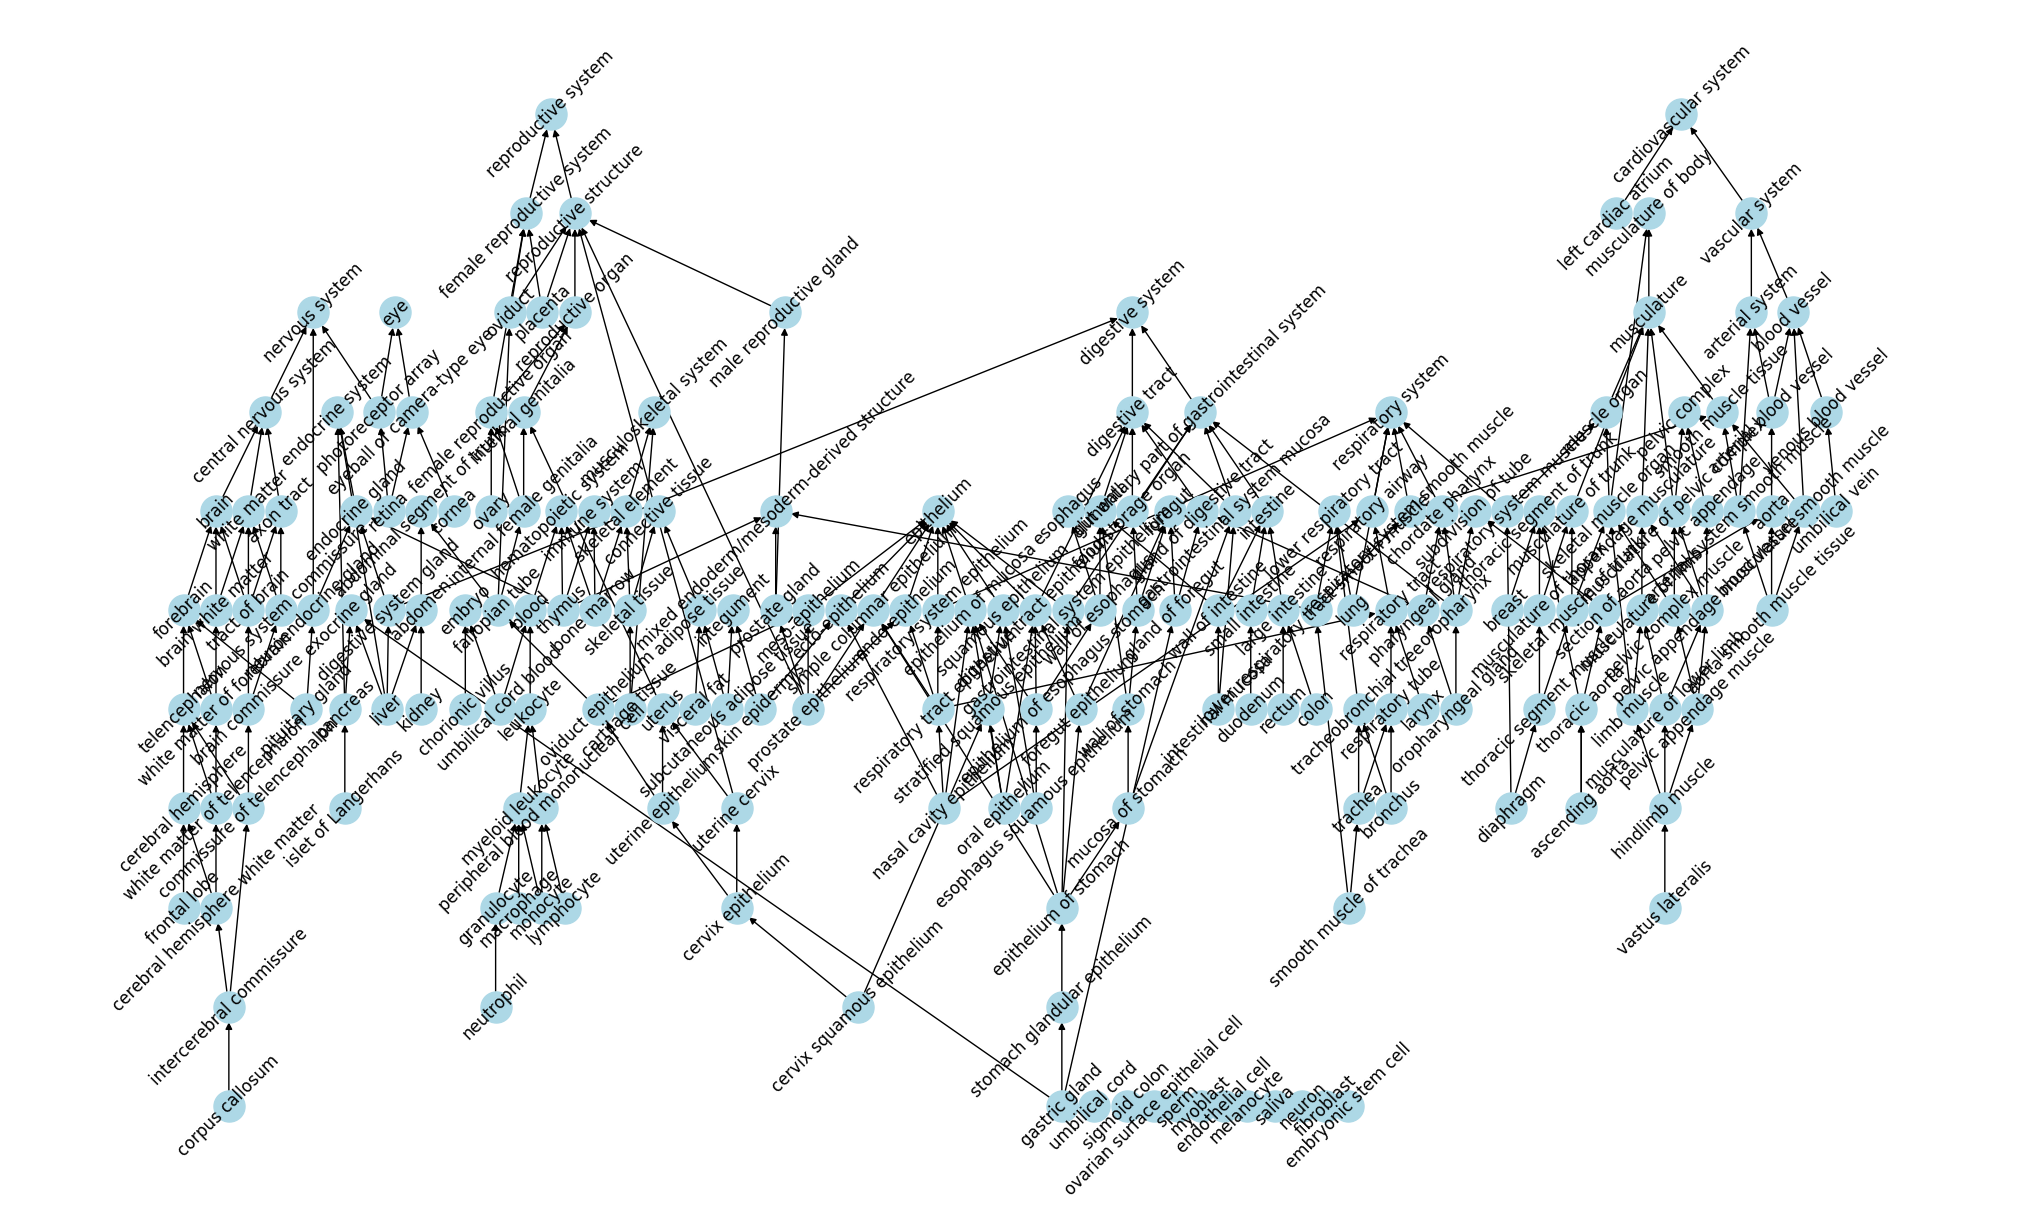

In [76]:
plt.figure(figsize=(20, 12))

# Draw the graph
nx.draw(zero_tree, zero_pos, node_color='lightblue', node_size=500, with_labels=False)

# Create a dictionary of labels using id_to_name
labels = {node: id_to_name[node] for node in zero_tree.nodes()}

# Add node labels using the translated names
text_items = nx.draw_networkx_labels(zero_tree, zero_pos, labels)

# Rotate the labels
for _, t in text_items.items():
    t.set_rotation(45)

# Show the plot
plt.axis('off')
plt.tight_layout()
plt.show()


In [111]:
ordered_keys = ['digestive system', 'musculature of body', 'nervous system', 'respiratory system', 'hematopoietic system','exocrine system'
                'connective tissue', 'cardiovascular system', 'abdominal segment of trunk', 'eye', 'reproductive system',
                'epithelium',
                'embryo', 
               ]

In [112]:
# all_nodes = [name_to_id[x] for x in single_meta['tissue_name'].unique()]

### MUST BE DAG 

all_nodes = [name_to_id[x] for x in zero_table.index]

node_groups = dict()
for big_node in sorted_nodes:
    big_children = nx.ancestors(zero_tree, big_node)
    if 'appendage' in id_to_name[big_node]:
        continue
    
    if len(big_children)==0: continue
    
    if 'epithelium' in id_to_name[big_node]: 
        big_children_in_nodes =  [node for node in all_nodes if node in big_children]
    else: 
        big_children_in_nodes = [node for node in all_nodes if ((node in big_children) and ('epithelium' not in id_to_name[node]))]
    if len(big_children_in_nodes)==0: continue
    
    all_nodes = list(set(all_nodes) - set(big_children_in_nodes))
    node_groups[id_to_name[big_node]] = [id_to_name[x] for x in big_children_in_nodes]
    
    if len(all_nodes)==0: break
node_groups

{'cardiovascular system': ['umbilical vein'],
 'reproductive system': ['fallopian tube'],
 'nervous system': ['retina', 'brain'],
 'digestive system': ['rectum',
  'gastric gland',
  'stomach',
  'intestine',
  'duodenum',
  'small intestine',
  'intestinal mucosa',
  'colon'],
 'endocrine system': ['thymus'],
 'respiratory system': ['bronchus', 'trachea', 'larynx'],
 'connective tissue': ['subcutaneous adipose tissue', 'adipose tissue'],
 'hematopoietic system': ['granulocyte', 'macrophage'],
 'epithelium': ['skin epidermis'],
 'embryo': ['chorionic villus']}

In [113]:
node_groups.keys()

dict_keys(['cardiovascular system', 'reproductive system', 'nervous system', 'digestive system', 'endocrine system', 'respiratory system', 'connective tissue', 'hematopoietic system', 'epithelium', 'embryo'])

In [114]:
def survey_zero(results, category_names, tissue=None, ax=None):
    """
    """
    neg_xlim = 1
    pos_xlim = 0.3
    
    results = dict(sorted(results.items()))
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data[:,0] = data[:,0]/neg_xlim
    data[:,1] = data[:,1]/pos_xlim
    data_cum = data.cumsum(axis=1)
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    if ax is None:
        ax = plt.subplot()
    else:
        ax = ax
        
    ax.set_xlim(-neg_xlim, pos_xlim)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels([1, 0, 0.3])


    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        offsets = data[:, 0]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color)
    
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

    return ax

Text(0.11, 0.5, 'Distance - minimum distance')

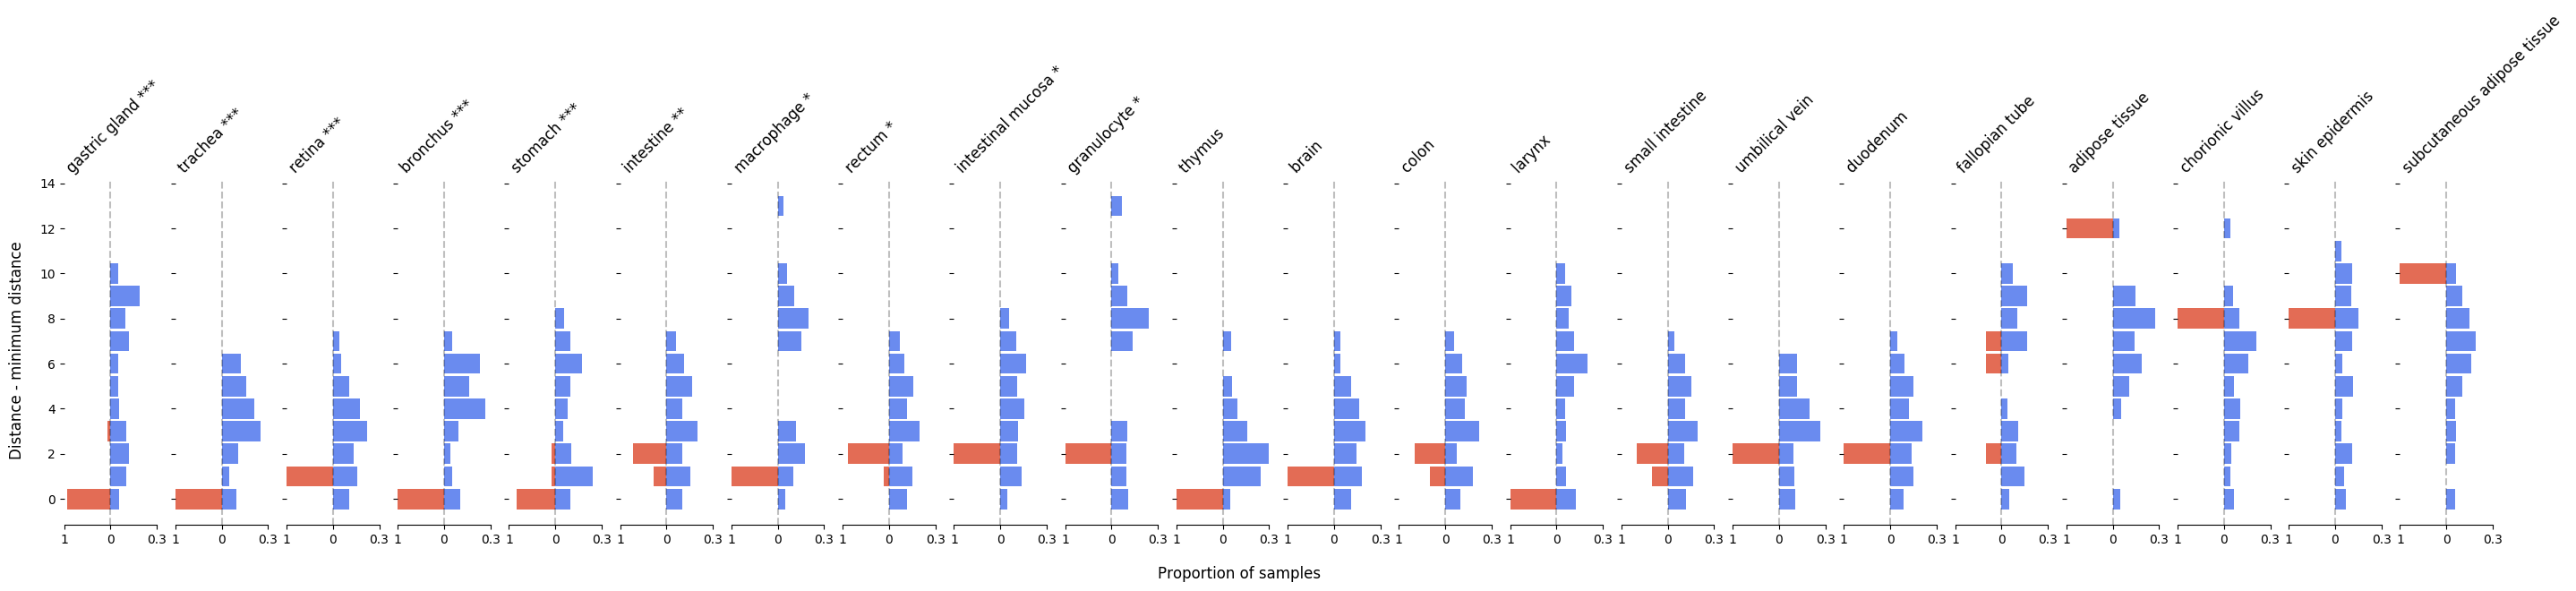

In [115]:
fig, ax = plt.subplots(1, len(df['tissue'].unique()), sharey=True, figsize=(35,5))

for i, tissue in enumerate(sorted_labels):
    ax[i] = survey_zero(list_to_bin_dict(df,[tissue]), 'sample_or_random', [tissue], ax[i])
    if tissue_to_pv[tissue]<0.001:
        sig="***"
    elif tissue_to_pv[tissue]<0.01:
        sig="**"
    elif tissue_to_pv[tissue]<0.05:
        sig="*"
    else:
        sig=""
    ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    
fig.text(0.5, 0, 'Proportion of samples', ha='center', va='center', fontsize=12)
fig.text(0.11, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, 1.25, 'ordered by x_pos', ha='center', va='center', fontsize=12)

# plt.tight_layout()
# plt.savefig("./../figures/zeroshot_hist.pdf", bbox_inches='tight', dpi=300)
# plt.show()

# plt.subplots_adjust(wspace=0)

# plt.ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))

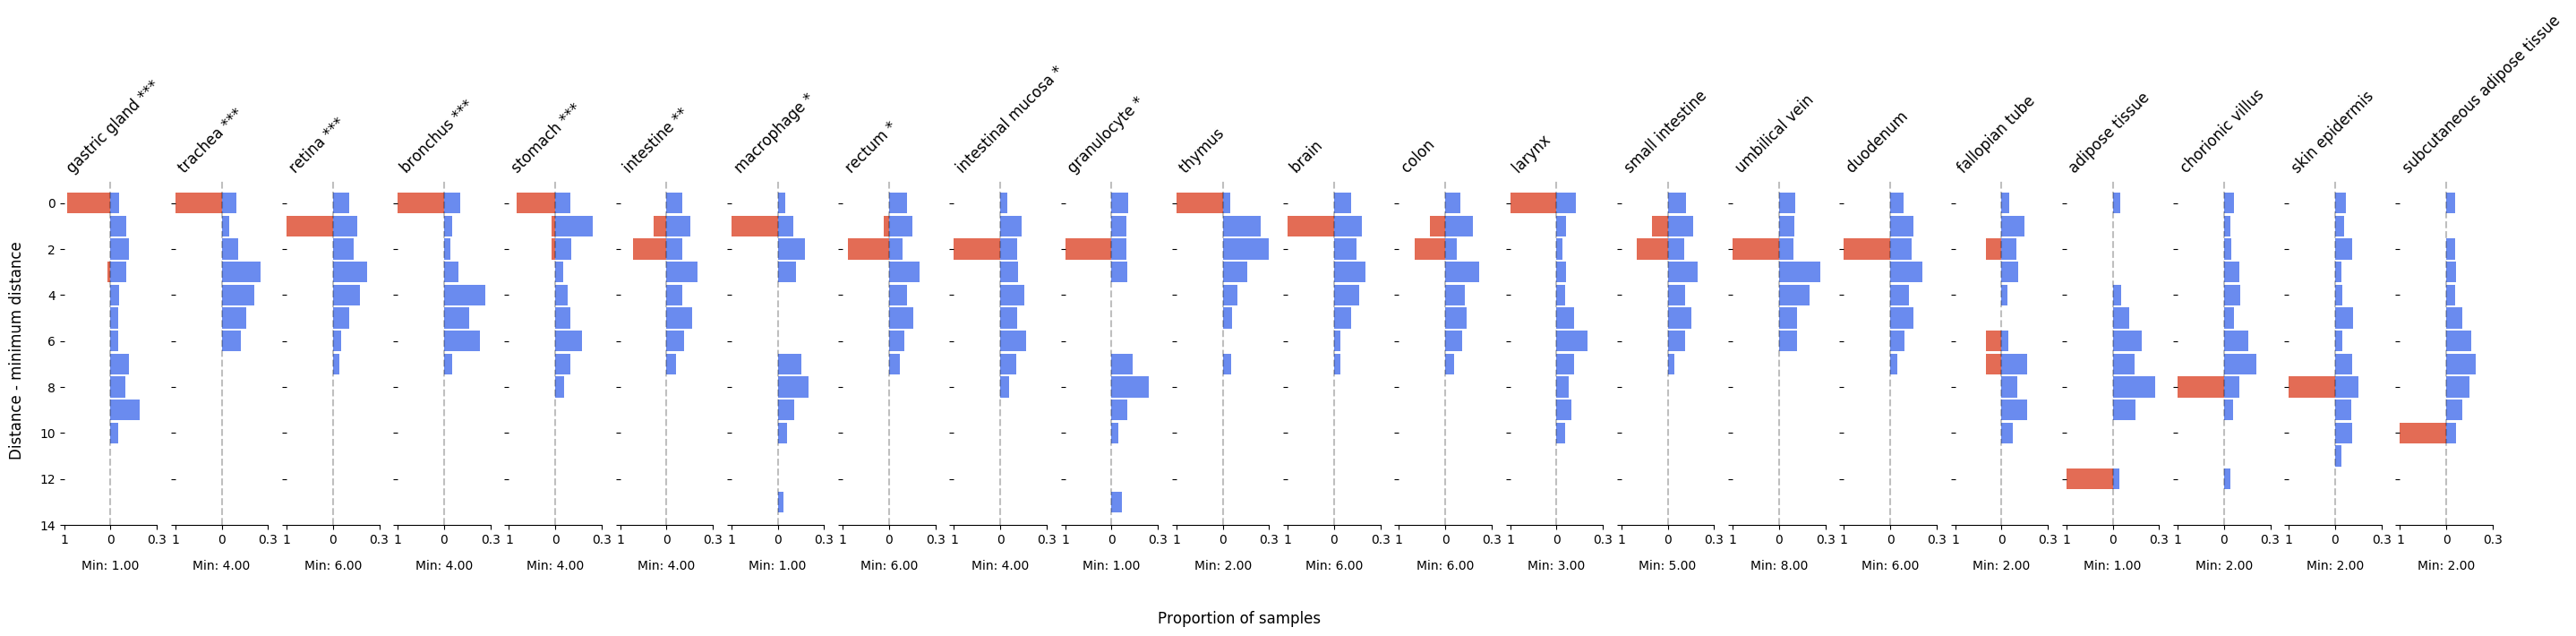

In [126]:
fig, ax = plt.subplots(1, len(df['tissue'].unique()), sharey=True, figsize=(35,5))

for i, tissue in enumerate(sorted_labels):
    ax[i].set_ylim(14, -1)
    ax[i] = survey_zero(list_to_bin_dict(df,[tissue]), 'sample_or_random', [tissue], ax[i])
    if tissue_to_pv[tissue]<0.001:
        sig="***"
    elif tissue_to_pv[tissue]<0.01:
        sig="**"
    elif tissue_to_pv[tissue]<0.05:
        sig="*"
    else:
        sig=""
    ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    # ax[i].set_title(f"{tissue}", rotation = 45, loc='left')
    tissue_min = min_distances[tissue]
    ax[i].text(0.5, -0.1, f"Min: {tissue_min:.2f}", ha='center', va='top', transform=ax[i].transAxes)

    
fig.text(0.5, -0.1, 'Proportion of samples', ha='center', va='center', fontsize=12)
fig.text(0.11, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)

plt.savefig("./../figures/zeroshot_hist.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [117]:
ordered_keys = [x for x in sorted_labels if x in df['tissue'].unique()]

In [118]:
labels = ['sample','random']
annot_pairs = [((tissue, labels[0]), (tissue, labels[1])) for tissue in node_groups.keys()]

combinations_p = list()
for (tissue1, sample1), (tissue1, random1) in annot_pairs:
    data1 = df[(df['tissue'].isin(node_groups[tissue1])) & (df['sample_or_random'] == sample1)]['distance']
    data1 = data1[data1.notna()]
    data2 = df[(df['tissue'].isin(node_groups[tissue1])) & (df['sample_or_random'] == random1)]['distance']
    data2 = data2[data2.notna()]
    # Significance
    U, p = mannwhitneyu(data1, data2, alternative="less")
    
    combinations_p.append([(tissue1, sample1), p])
        
rejected, p_adjusted = fdrcorrection([pv for comb, pv in combinations_p])
significant_combinations = [(comb, p_adj) for comb, p_adj in zip(annot_pairs, p_adjusted) 
                            if p_adj<0.05]
group_to_pv = {comb[0][0]: p_adj for comb, p_adj in zip(annot_pairs, p_adjusted)}

group_to_pv

{'cardiovascular system': 0.13917707455977923,
 'reproductive system': 0.4872608159448966,
 'nervous system': 4.082182316327275e-09,
 'digestive system': 4.433392902400436e-27,
 'endocrine system': 0.09109826191082407,
 'respiratory system': 1.853161238711768e-16,
 'connective tissue': 0.9999982769509191,
 'hematopoietic system': 0.0024847237067942866,
 'epithelium': 0.9999982769509191,
 'embryo': 0.9999982769509191}

In [119]:
sorted_groups = [x for x in sorted(node_groups.keys(), key=lambda x: group_to_pv[x])]
sorted_groups

['digestive system',
 'respiratory system',
 'nervous system',
 'hematopoietic system',
 'endocrine system',
 'cardiovascular system',
 'reproductive system',
 'connective tissue',
 'epithelium',
 'embryo']

In [120]:
save_dill = True

if save_dill:
    with open('zeroshot_df', 'wb') as f:
        dill.dump(df, f)

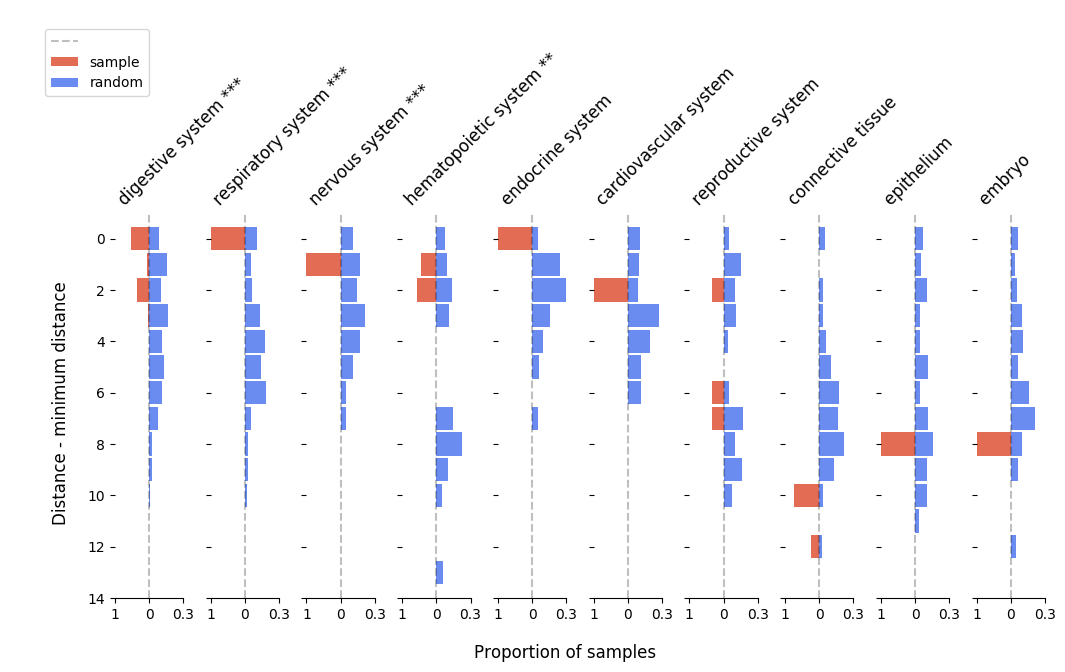

In [121]:
fig, ax = plt.subplots(1, len(node_groups.keys()), sharey=True, figsize=(12,5))

for i, tissue in enumerate(sorted_groups):
    ax[i].set_ylim(14, -1)
    ax[i] = survey_zero(list_to_bin_dict(df, node_groups[tissue]), 'sample_or_random', node_groups[tissue], ax[i])
    if group_to_pv[tissue]<0.001:
        sig="***"
    elif group_to_pv[tissue]<0.01:
        sig="**"
    elif group_to_pv[tissue]<0.05:
        sig="*"
    else:
        sig=""
    ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    # ax[i].set_title(f"{tissue}", rotation = 45, loc='left')
    
fig.subplots_adjust(wspace=0.4)
    
fig.text(0.5, 0, 'Proportion of samples', ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
fig.legend(["", "sample","random"], bbox_to_anchor=(0.13, 1.3))

plt.savefig("./../figures/zeroshot_grouped.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [88]:
# fig, ax = plt.subplots(1, len(node_groups.keys()), sharey=True, figsize=(13,5))

# for i, tissue in enumerate(sorted_groups):
#     ax[i].set_ylim(14, -1)
#     ax[i] = survey_zero(list_to_bin_dict(df, node_groups[tissue]), 'sample_or_random', node_groups[tissue], ax[i])
#     if group_to_pv[tissue]<0.001:
#         sig="***"
#     elif group_to_pv[tissue]<0.01:
#         sig="**"
#     elif group_to_pv[tissue]<0.05:
#         sig="*"
#     else:
#         sig=""
#     ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
#     # ax[i].set_title(f"{tissue}", rotation = 45, loc='left')
    
# fig.text(0.5, 0, 'Proportion of samples', ha='center', va='center', fontsize=12)
# fig.text(0.08, 0.5, 'Distance - minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
# fig.legend(["", "sample","random"], bbox_to_anchor=(0.13, 1.3))

In [89]:
max_dist = 0
for i, tissue in enumerate(sorted_labels):
    if max(list(list_to_bin_dict(df,[tissue]).keys())) > max_dist: max_dist =  max(list(list_to_bin_dict(df,[tissue]).keys()))
max_dist

13

In [90]:
tissue_df = pd.DataFrame(index=range(max_dist+1))
for i, tissue in enumerate(sorted_labels):
    tissue_df[[tissue, f'{tissue} random']] = pd.DataFrame.from_dict(list_to_bin_dict(df, [tissue]), orient='index', columns=[tissue, f'{tissue} random'])
tissue_df

,gastric gland,gastric gland random,trachea,trachea random,retina,retina random,bronchus,bronchus random,stomach,stomach random,...,fallopian tube,fallopian tube random,adipose tissue,adipose tissue random,chorionic villus,chorionic villus random,skin epidermis,skin epidermis random,subcutaneous adipose tissue,subcutaneous adipose tissue random
0,0.928571,0.057034,1.0,0.096401,0.0,0.103362,1.0,0.102662,0.833333,0.098504,...,0.000000,0.049618,0.0,0.048507,0.0,0.066835,0.0,0.067568,0.0,0.055767
1,0.000000,0.105196,0.0,0.051414,1.0,0.158157,0.0,0.049430,0.083333,0.241895,...,0.000000,0.151399,NaN,NaN,0.0,0.039092,0.0,0.055283,NaN,NaN
2,0.000000,0.120406,0.0,0.107969,0.0,0.135741,0.0,0.039290,0.083333,0.105985,...,0.333333,0.097964,NaN,NaN,0.0,0.050441,0.0,0.109337,0.0,0.058302
3,0.071429,0.102662,0.0,0.253213,0.0,0.220423,0.0,0.091255,0.000000,0.053616,...,0.000000,0.108142,NaN,NaN,0.0,0.102144,0.0,0.040541,0.0,0.064639
4,0.000000,0.054499,0.0,0.210797,0.0,0.173101,0.0,0.267427,0.000000,0.082294,...,0.000000,0.038168,0.0,0.054726,0.0,0.105927,0.0,0.047912,0.0,0.057034
5,0.000000,0.053232,0.0,0.158098,0.0,0.108344,0.0,0.163498,0.000000,0.094763,...,NaN,NaN,0.0,0.104478,0.0,0.063052,0.0,0.116708,0.0,0.101394
6,0.000000,0.053232,0.0,0.122108,0.0,0.056040,0.0,0.231939,0.000000,0.170823,...,0.333333,0.047074,0.0,0.185323,0.0,0.158890,0.0,0.047912,0.0,0.159696
7,0.000000,0.119138,NaN,NaN,0.0,0.044832,0.0,0.054499,0.000000,0.096010,...,0.333333,0.169211,0.0,0.140547,0.0,0.209332,0.0,0.110565,0.0,0.191381
8,0.000000,0.096324,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.056110,...,0.000000,0.101781,0.0,0.273632,1.0,0.100883,1.0,0.153563,0.0,0.152091
9,0.000000,0.187579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.164122,0.0,0.149254,0.0,0.060530,0.0,0.101966,0.0,0.100127


In [91]:
print(tissue_df.T.round(2).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
{} &     0 &     1 &     2 &     3 &     4 &     5 &     6 &     7 &     8 &     9 &    10 &    11 &    12 &    13 \\
\midrule
gastric gland                      &  0.93 &  0.00 &  0.00 &  0.07 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &   NaN &   NaN &   NaN \\
gastric gland random               &  0.06 &  0.11 &  0.12 &  0.10 &  0.05 &  0.05 &  0.05 &  0.12 &  0.10 &  0.19 &  0.05 &   NaN &   NaN &   NaN \\
trachea                            &  1.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN \\
trachea random                     &  0.10 &  0.05 &  0.11 &  0.25 &  0.21 &  0.16 &  0.12 &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN \\
retina                             &  0.00 &  1.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN \\
retina random                      &  0.10 &  0.16 &  0.14 &  0.22 &  0.17 &  0.1

In [92]:
# fig, ax = plt.subplots(1, len(df['tissue'].unique()), sharey=True, figsize=(35,5))

# for i, tissue in enumerate(sorted(tissue_to_pv, key=tissue_to_pv.get)):
#     ax[i] = survey(list_to_bin_dict(df,tissue), category_names, tissue, ax[i])
#     if tissue_to_pv[tissue]<0.001:
#         sig="***"
#     elif tissue_to_pv[tissue]<0.01:
#         sig="**"
#     elif tissue_to_pv[tissue]<0.05:
#         sig="*"
#     else:
#         sig=""
#     ax[i].set_title(f"{tissue} {sig}", rotation = 45, loc='left')
    
# fig.text(0.5, 0, 'Propertion of samples', ha='center', va='center', fontsize=12)
# fig.text(0.11, 0.5, 'Distance - Minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, 1.25, 'ordered by pvalue', ha='center', va='center', fontsize=12)

# plt.tight_layout()
# plt.show()

# # plt.subplots_adjust(wspace=0)

# # plt.ylim(min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1]))

In [93]:
# fig, ax = plt.subplots(1, len(df['tissue'].unique()), sharey=True, figsize=(35,5))

# for i, tissue in enumerate(df['tissue'].unique()):
#     ax[i] = survey(list_to_bin_dict(df,tissue), category_names, tissue, ax[i])
    
# fig.text(0.5, 0, 'Propertion of samples', ha='center', va='center', fontsize=12)
# fig.text(0.11, 0.5, 'Distance - Minimum distance', ha='center', va='center', rotation='vertical', fontsize=12)

# # for i, artist in enumerate(ax.artists):
# #     if i % 2 == 0:
# #         artist.set_facecolor('grey')

# add_stat_annotation(ax, data=df, x='tissue', y='distance', hue='sample_or_random',
#                     box_pairs=annot_pairs,
#                     # test='Mann-Whitney-gt', 
#                     perform_stat_test=False,
#                     pvalues=[pv for comb, pv in all_combinations],
#                     text_format='star', 
#                     loc='inside', 
#                     verbose=0,
#                     # comparisons_correction="fdr_bh"
#                    )

# plt.tight_layout()
# plt.show()

In [94]:
# # Create a figure with two subplots
# plt.figure(figsize=(25,8))

# ax = sns.violinplot(x="tissue", y="distance", hue="sample_or_random", data=df, cut=0, split=True, inner="quartile", palette=custom_palette)
# # Adjust layout
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
# # Set font size for tick labels on both axes
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Set font size for axis labels
# ax.set_xlabel('Tissue', fontsize=12)
# ax.set_ylabel('Distance - minimum', fontsize=12)

# for i, artist in enumerate(ax.artists):
#     if i % 2 == 0:
#         artist.set_facecolor('grey')

# add_stat_annotation(ax, data=df, x='tissue', y='distance', hue='sample_or_random',
#                     box_pairs=annot_pairs,
#                     # test='Mann-Whitney-gt', 
#                     perform_stat_test=False,
#                     pvalues=[pv for comb, pv in all_combinations],
#                     text_format='star', 
#                     loc='inside', 
#                     verbose=0,
#                     # comparisons_correction="fdr_bh"
#                    )
# plt.title("Sample-wise average distance")

# plt.tight_layout()
# plt.show()

In [95]:
# # Select all odd columns
# odd_columns = df.iloc[:, 1::2]
# even_columns = df.iloc[:, 0::2]

# # Combine values from all odd columns into a new column 'combined'
# pred_combined = even_columns.values.flatten().tolist()
# # pred_combined = list(filter(lambda x: not np.isnan(x), odd_columns.values.flatten().tolist()))
# random_combined = odd_columns.values.flatten().tolist()

# combined_dict = dict()
# combined_dict['pred_combined'] = pred_combined
# combined_dict['random_combined'] = random_combined

# combined_df = pd.DataFrame.from_dict(combined_dict)

# sns.stripplot(data=combined_df, jitter=True, palette=custom_palette)

# for no prediction, get highest probability

In [96]:
list(single_meta[single_meta['tissue_name']==tissue].index)

['GSM3015190',
 'GSM3015191',
 'GSM3015192',
 'GSM3015193',
 'GSM3015194',
 'GSM3015195']

In [97]:
no_pred_indices = pred_name[pred_name == ()].index
no_pred_distances = pd.Series(index=no_pred_indices)

for idx in no_pred_indices:
    highest_pred = pred_proba_df.loc[idx].idxmax()
    no_pred_distances[idx] = get_distance(zero_tree_undirected, [true.loc[idx], highest_pred], n_type="name", display=False)

no_pred_distances_per_tissue = {
    tissue: no_pred_distances.loc[group.index.intersection(no_pred_indices)].tolist()
    for tissue, group in single_meta.groupby('tissue_name')
}

In [98]:
from collections import Counter

no_pred_indices = pred_name[pred_name == ()].index
highest_preds_per_tissue = {}

for tissue, group in single_meta.groupby('tissue_name'):
    tissue_indices = group.index.intersection(no_pred_indices)
    if len(tissue_indices) > 0:
        highest_preds = pred_proba_df.loc[tissue_indices].idxmax(axis=1)
        pred_counter = Counter(highest_preds)
        sorted_pred_counts = sorted(pred_counter.items(), key=lambda x: x[1], reverse=True)
        highest_preds_per_tissue[tissue] = sorted_pred_counts

# Print or use the results
for tissue, pred_counts in highest_preds_per_tissue.items():
    print(f"\n{tissue}:")
    for pred, count in pred_counts:
        print(f"  {pred}: {count}")


adipose tissue:
  breast: 2
  myoblast: 1
  fibroblast: 1

ascending aorta:
  pancreas: 6

bone marrow:
  myoblast: 8
  fibroblast: 2

brain:
  exocrine gland: 6
  pancreas: 1

cartilage tissue:
  fibroblast: 3
  myoblast: 2

cervix squamous epithelium:
  saliva: 9
  simple columnar epithelium: 1

cornea:
  reproductive structure: 2
  simple columnar epithelium: 1
  umbilical cord blood: 1

corpus callosum:
  exocrine gland: 5

diaphragm:
  myoblast: 1

endothelial cell:
  blood: 2

esophagus:
  islet of Langerhans: 1
  pancreas: 1

esophagus squamous epithelium:
  saliva: 6
  breast: 2
  islet of Langerhans: 1

fallopian tube:
  visceral fat: 4
  pancreas: 1

frontal lobe:
  exocrine gland: 2
  breast: 1

intestine:
  visceral fat: 1

kidney:
  exocrine gland: 3
  simple columnar epithelium: 2
  fibroblast: 1
  reproductive structure: 1

larynx:
  breast: 6
  nasal cavity epithelium: 1
  saliva: 1
  exocrine gland: 1

left cardiac atrium:
  visceral fat: 4

lung:
  exocrine gland: 7


In [99]:
no_pred_indices = pred_name[pred_name == ()].index
all_tissues = set(single_meta['tissue_name'])
tissues_with_predictions = set(single_meta.loc[~single_meta.index.isin(no_pred_indices), 'tissue_name'])
tissues_all_no_pred = all_tissues - tissues_with_predictions
print(len(all_tissues))
print(len(tissues_with_predictions))

highest_preds_per_tissue = {}

for tissue in tissues_all_no_pred:
    tissue_indices = single_meta[single_meta['tissue_name'] == tissue].index
    highest_preds = pred_proba_df.loc[tissue_indices].idxmax(axis=1)
    pred_counter = Counter(highest_preds)
    sorted_pred_counts = sorted(pred_counter.items(), key=lambda x: x[1], reverse=True)
    highest_preds_per_tissue[tissue] = sorted_pred_counts

for tissue, pred_counts in highest_preds_per_tissue.items():
    print(f"\n{tissue}:")
    for pred, count in pred_counts[:5]:  # Show top 5 predictions
        print(f"  {pred}: {count}")

49
35

corpus callosum:
  exocrine gland: 5

kidney:
  exocrine gland: 3
  simple columnar epithelium: 2
  fibroblast: 1
  reproductive structure: 1

neuron:
  pancreas: 26
  exocrine gland: 3

ovary:
  pancreas: 2

cartilage tissue:
  fibroblast: 3
  myoblast: 2

diaphragm:
  myoblast: 1

ascending aorta:
  pancreas: 6

oropharyngeal gland:
  breast: 10
  saliva: 2
  pancreas: 2
  nasal cavity epithelium: 1
  exocrine gland: 1

cornea:
  reproductive structure: 2
  simple columnar epithelium: 1
  umbilical cord blood: 1

frontal lobe:
  exocrine gland: 2
  breast: 1

left cardiac atrium:
  visceral fat: 4

pituitary gland:
  exocrine gland: 6

esophagus:
  islet of Langerhans: 1
  pancreas: 1

oral epithelium:
  breast: 6
  saliva: 1


In [105]:
no_predictions_mean[tissue] = np.nanmin([get_distance(zero_tree_undirected, [tissue, ours], n_type="name")
                                 for ours in [id_to_name[node] for node in subtree.nodes]])

3

In [110]:
highest_preds_per_tissue = {}
distance_summary_per_tissue = {}

for tissue in tissues_all_no_pred:
    tissue_indices = single_meta[single_meta['tissue_name'] == tissue].index
    highest_preds = pred_proba_df.loc[tissue_indices].idxmax(axis=1)
    pred_counter = Counter(highest_preds)
    sorted_pred_counts = sorted(pred_counter.items(), key=lambda x: x[1], reverse=True)
    highest_preds_per_tissue[tissue] = sorted_pred_counts
    
    distances = []
    for idx in tissue_indices:
        true_label = true.loc[idx]
        pred_label = highest_preds[idx]
        distance = get_distance(zero_tree_undirected, [true_label, pred_label], n_type="name", display=False)
        distances.append(distance)
    
    # Calculate distance summary
    distances = no_pred_distances_per_tissue[tissue]
    tissue_min_dist = np.nanmin([get_distance(zero_tree_undirected, [tissue, ours], n_type="name")
                                 for ours in [id_to_name[node] for node in subtree.nodes]])
    distances = np.array(distances)-tissue_min_dist

    # print(tissue, distances)
    if np.isnan(distances).all():
        distance_summary = {
            'mean': np.nan,
            'median': np.nan,
            'min': np.nan,
            'max': np.nan
        }
    else:
        valid_distances = distances[~np.isnan(distances)]
        distance_summary = {
            'mean': np.mean(valid_distances),
            'median': np.median(valid_distances),
            'min': np.min(valid_distances),
            'max': np.max(valid_distances)
        }
    distance_summary_per_tissue[tissue] = distance_summary

for tissue in tissues_all_no_pred:
    print(f"\n{tissue}:")
    print(f"in graph: {utils.name_to_id[tissue] in zero_tree.nodes()},isolate: {nx.is_isolate(zero_tree_undirected, utils.name_to_id[tissue])}")
    print("Top 5 predictions:")
    for pred, count in highest_preds_per_tissue[tissue][:5]:
        print(f"  {pred}: {count}")
    print("Distance summary:")
    for metric, value in distance_summary_per_tissue[tissue].items():
        print(f"  {metric}: {value:.4f}")



corpus callosum:
in graph: True,isolate: False
Top 5 predictions:
  exocrine gland: 5
Distance summary:
  mean: 1.0000
  median: 1.0000
  min: 1.0000
  max: 1.0000

kidney:
in graph: True,isolate: False
Top 5 predictions:
  exocrine gland: 3
  simple columnar epithelium: 2
  fibroblast: 1
  reproductive structure: 1
Distance summary:
  mean: 2.6667
  median: 2.0000
  min: 1.0000
  max: 5.0000

neuron:
in graph: True,isolate: True
Top 5 predictions:
  pancreas: 26
  exocrine gland: 3
Distance summary:
  mean: nan
  median: nan
  min: nan
  max: nan

ovary:
in graph: True,isolate: False
Top 5 predictions:
  pancreas: 2
Distance summary:
  mean: 5.0000
  median: 5.0000
  min: 5.0000
  max: 5.0000

cartilage tissue:
in graph: True,isolate: False
Top 5 predictions:
  fibroblast: 3
  myoblast: 2
Distance summary:
  mean: nan
  median: nan
  min: nan
  max: nan

diaphragm:
in graph: True,isolate: False
Top 5 predictions:
  myoblast: 1
Distance summary:
  mean: nan
  median: nan
  min: nan
  

# confmat

In [101]:
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

def combine_qualitative_cmaps(cmap1, cmap2):
    # Get the colors from both colormaps
    colors1 = cmap1.colors
    colors2 = cmap2.colors

    # Combine the colors
    combined_colors = colors1 + colors2

    # Create and return a new qualitative colormap
    return plt.cm.colors.ListedColormap(combined_colors)

def generate_colors(n):
    # cmap = plt.get_cmap('rainbow')
    # cmap = plt.get_cmap('gist_rainbow')
    # cmap = plt.get_cmap('gist_ncar')
    # cmap = plt.get_cmap('hsv')
    # cmap = plt.get_cmap('nipy_spectral')
    cmap1 = plt.get_cmap('Set1')
    cmap2 = plt.get_cmap('Set2')
    # combine them and build a new colormap
    cmap = combine_qualitative_cmaps(cmap1, cmap2)
    # rgba_colors = cmap(np.linspace(0, 1, n))
    rgba_colors = cmap.colors[:n]
    hex_colors = [mcolors.to_hex(color) for color in rgba_colors]
    
    # hex_colors = [
    #     '#e6194B', '#3cb44b', '#ffe119', '#4363d8', 
    #     '#f58231', '#911eb4', '#42d4f4', 
    #     '#f032e6', '#bfef45', '#fabed4', 
    #     '#469990', '#dcbeff', '#9A6324', 
    #     '#fffac8', '#800000', '#aaffc3', 
    #     '#808000', '#ffd8b1', '#000075', 
    #     '#a9a9a9', '#ffffff', '#000000'
    # ]
    
    hex_colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#bcf60c",  "#800000",
    "#008080",  "#e6beff", "#f032e6", "#fabebe", "#9a6324", "#fffac8",
    "#aaffc3", "#808000", "#ffd8b1", "#000075", "#808080"
    ]

    return hex_colors

def generate_gradient_colors(base_color, n):
    base_rgb = mcolors.hex2color(base_color)
    r, g, b = base_rgb

    gradients = []
    buffer = 4
    # n = n+buffer
    for i in range(n):
        factor = i / (n) if n > 1 else 0.0
        gradient_color = (r + (1 - r) * factor, g + (1 - g) * factor, b + (1 - b) * factor)
        # gradient_color = (r * factor, g * factor, b * factor)
        # if i>(buffer-1): gradients.append(gradient_color)
        gradients.append(gradient_color)

    return gradients

def show_color_dots(colors):
    num_colors = len(colors)

    # Create a scatter plot with colored dots
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.scatter(range(num_colors), [1] * num_colors, color=colors, s=1000)

    # Hide axes and labels
    ax.axis('off')

    plt.show()

def get_family_colors(subtree, display=False):
    '''
    uses generate_colors(), generate_gradient_colors()
    '''
    families = [list(x) for x in nx.weakly_connected_components(subtree)]
    families.sort(key=len, reverse=True)
    colors = generate_colors(len(families))
    print(colors)
    ordered = list()
    member_color = dict()
    for i, family in enumerate(families):
        member_children = {id_to_name[member]: [id_to_name[x] for x in nx.ancestors(subtree, member)] for member in family}
        
        head = max(member_children, key=lambda k: len(member_children[k]))
        family_tree = subtree.subgraph(family)
        # nx.draw(family_tree, with_labels=True
        family_ordered = list(reversed(list(nx.topological_sort(family_tree))))
        gradient_colors = generate_gradient_colors(colors[i], len(family))
        # print(gradient_colors)
        
        if display:
            show_color_dots(gradient_colors)
                                                                                
        member_color.update({id_to_name[member]:gradient_colors[j] for j, member in enumerate(family_ordered)})
        ordered.extend([id_to_name[member] for member in family_ordered])
        
    return member_color, ordered

In [127]:
# with open("colors_ordered", "rb") as f:
#     colors, ordered = dill.load(f)

In [103]:
zero_colors, zero_ordered = get_family_colors(zero_tree, display=False)

['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#bcf60c', '#800000', '#008080', '#e6beff', '#f032e6', '#fabebe', '#9a6324', '#fffac8', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']


In [104]:
confmat=pd.DataFrame(columns=mlb.classes_)
for tissue in [x for x in zero_ordered if x in true.unique()]:
    confmat.loc[tissue] = mlb.transform(pred_name[true==tissue]).sum(axis=0)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(confmat[ordered].astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
plt.xlabel('Predicted (multilabel)', fontsize=12)
plt.ylabel('True (single zero-shot label)', fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.savefig("./../figures/confusionmatrix_zero.pdf", bbox_inches='tight')
plt.show()

In [ ]:
node_y_pos = {node: -zero_pos[node][1] for node in zero_tree.nodes()}

# Sort labels based on x positions
sorted_labels = [id_to_name[x] for x in sorted(zero_tree.nodes(), key=lambda node: node_y_pos[node])]
sorted_labels = sorted(sorted_labels, key=lambda x: 'system' not in x)

In [ ]:
node_groups = dict()
all_nodes = [name_to_id[x] for x in true.unique()]

for big_node in sorted_labels:
    # print(big_node)
    big_node = name_to_id[big_node]
    big_children = nx.ancestors(filtered_uberon, big_node)
    if len(big_children)==0: continue
    
    ### if epithelium matters
    # if 'epithelium' in id_to_name[big_node]: 
    #     # print(id_to_name[big_node])
    #     big_children_in_nodes =  [node for node in all_nodes if node in big_children]
    # else: 
    #     big_children_in_nodes = [node for node in all_nodes if ((node in big_children) and ('epithelium' not in id_to_name[node]))]

    big_children_in_nodes =  [node for node in all_nodes if node in big_children]
    
    
    if len(big_children_in_nodes)==0: 
        continue
    
    all_nodes = list(set(all_nodes) - set(big_children_in_nodes))
    node_groups[id_to_name[big_node]] = [id_to_name[x] for x in big_children_in_nodes]
    
    # print([id_to_name[x] for x in all_nodes])
    if len(all_nodes)==0: break
node_groups

In [ ]:
confmat_grouped = pd.DataFrame(columns=mlb.classes_)
for group in node_groups.keys():
    confmat_grouped.loc[group] = mlb.transform(pred_name[true.isin(node_groups[group])]).sum(axis=0)

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confmat_grouped[ordered].astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
plt.xlabel('Predicted (multilabel)', fontsize=12)
plt.ylabel('True (grouped label)', fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.savefig("./../figures/confusionmatrix_zero_grouped.pdf", bbox_inches='tight')
plt.show()

In [ ]:
meta_node_y_pos = {node: -pos[node][1] for node in subtree.nodes()}

# Sort labels based on x positions
meta_sorted_labels = [id_to_name[x] for x in sorted(subtree.nodes(), key=lambda node: meta_node_y_pos[node]) if id_to_name[x] in mlb.classes_]
meta_sorted_labels

In [ ]:
meta_node_groups = dict()
pred_all_nodes = [name_to_id[x] for x in pd.unique(pd.DataFrame(mlb.inverse_transform(pred)).stack())]

for big_node in node_groups.keys():
    big_node = name_to_id[big_node]
    big_children = nx.ancestors(filtered_uberon, big_node)
    if len(big_children)==0: continue
    
    if 'epithelium' in id_to_name[big_node]: 
        big_children_in_nodes =  [node for node in pred_all_nodes if node in big_children]
    else: 
        big_children_in_nodes = [node for node in pred_all_nodes if ((node in big_children) and ('epithelium' not in id_to_name[node]))]
    
    if len(big_children_in_nodes)==0: 
        continue
    
    pred_all_nodes = list(set(pred_all_nodes) - set(big_children_in_nodes))
    meta_node_groups[id_to_name[big_node]] = [id_to_name[x] for x in big_children_in_nodes]
    
    if len(pred_all_nodes)==0: break
    
if len(pred_all_nodes)!=0:
    meta_node_groups.update({id_to_name[x]:[id_to_name[x]] for x in pred_all_nodes})

meta_node_groups

In [ ]:
confmat_grouped_grouped = pd.DataFrame(columns=meta_node_groups.keys())
for group in meta_node_groups.keys():
    # node_group = [x for x in meta_node_groups[group] if x in ]
    node_group = meta_node_groups[group]
    
    if len(node_group)==0:
        print(group)
    else:
        confmat_grouped_grouped[group] = confmat_grouped[node_group].sum(axis=1)
confmat_grouped_grouped

In [ ]:
meta_node_groups

In [ ]:
confmat_true_grouped = pd.DataFrame(index=confmat.index, columns=meta_node_groups.keys())
for group in meta_node_groups.keys():
    node_group = [id_to_name[x] for x in nx.ancestors(filtered_uberon, name_to_id[group])]
    node_group += [group]
    node_group_columns = [x for x in confmat.columns if x in node_group]
    confmat_true_grouped[group] = confmat[node_group_columns].sum(axis=1)
    if group=='exocrine gland':
        print(group)
        print(node_group_columns)
confmat_true_grouped

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confmat_grouped_grouped.astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
plt.xlabel('Predicted (multilabel)', fontsize=12)
plt.ylabel('True (grouped label)', fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
# plt.savefig("./../figures/confusionmatrix_zero_grouped.pdf", bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(6,10))
sns.heatmap(confmat_true_grouped.fillna(0).astype(int), 
            annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 10})
plt.xlabel('Predicted (multilabel)', fontsize=12)
plt.ylabel('True (grouped label)', fontsize=12)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
# plt.savefig("./../figures/confusionmatrix_zero_grouped.pdf", bbox_inches='tight')
plt.show()

In [ ]:
confmat_grouped_grouped_reordered = confmat_grouped_grouped.loc[[x for x in confmat_grouped_grouped.columns if x in confmat_grouped_grouped.index]]

In [ ]:
for x in confmat_grouped_grouped.index:
    if x not in confmat_grouped_grouped_reordered.index:
        confmat_grouped_grouped_reordered.loc[x] = confmat_grouped_grouped.loc[x]
confmat_grouped_grouped_reordered

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confmat_grouped_grouped_reordered.astype(int), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 12})
plt.xlabel('Predicted (grouped, multilabel)', fontsize=12)
plt.ylabel('True (grouped)', fontsize=12)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
# plt.savefig("./../figures/confusionmatrix_zero_grouped.pdf", bbox_inches='tight')
plt.show()

### confmat cluster

In [ ]:
true_counts = true.value_counts()
confmat_normalized = confmat.apply(lambda row: row / true_counts[row.name], axis=1)

In [ ]:
plt.figure()
cg = sns.clustermap(confmat.astype(int),yticklabels=True, xticklabels=True)
# plt.xticks(rotation=45)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
cg = sns.clustermap(confmat_normalized.astype(int), xticklabels=True, yticklabels=True)
# plt.xticks(rotation=45)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

In [ ]:
all_indices = set(range(len(confmat)))
missing_indices = all_indices - set(np.concatenate(list(node_groups.values())))
for idx in missing_indices:
    node_groups[f'Missing_{idx}'] = [idx]

In [ ]:
# Create a dictionary to map row indices to groups
row_group_mapping = {idx: group for group, indices in node_groups.items() for idx in indices}

# Create a custom color palette for rows based on the grouping
row_colors = pd.Series(confmat.index).map(row_group_mapping).map(lambda x: sns.color_palette("Paired", len(node_groups))[list(node_groups.keys()).index(x)])

# Create a dictionary to map column indices to groups
col_group_mapping = {idx: group for group, indices in node_groups.items() for idx in indices}

# Create a custom color palette for columns based on the grouping
col_colors = pd.Series(confmat.columns).map(col_group_mapping).map(sns.color_palette("Paired"))

# Plot the clustermap
sns.clustermap(confmat, row_colors=row_colors, col_colors=col_colors, cmap="YlGnBu")
plt.show()


In [ ]:
confmat_tg_normalized = confmat_true_grouped.apply(lambda row: row / true_counts[row.name], axis=1)

In [ ]:
plt.figure()
cg = sns.clustermap(confmat_true_grouped.astype(int),yticklabels=True, xticklabels=True)
# plt.xticks(rotation=45)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

In [ ]:
plt.figure()
cg = sns.clustermap(confmat_tg_normalized.astype(int),yticklabels=True, xticklabels=True)
# plt.xticks(rotation=45)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.show()

### sankey

In [ ]:
import plotly.graph_objects as go
from collections import Counter

In [ ]:
# Example lists of true labels and predicted labels
true_labels = true.values
predicted_labels = pred_name.values

# Initialize an empty list to store expanded pairs
expanded_pairs = []

# Iterate through each true label and corresponding predicted labels
for true_label, predicted_list in zip(true_labels, predicted_labels):
    # Check if predicted_list is empty
    if not predicted_list:
        expanded_pairs.append((true_label, 'NA'))
    else:
        # Create pairs for each predicted label with the current true label
        pairs = [(true_label, predicted_label) for predicted_label in predicted_list]
        expanded_pairs.extend(pairs)

# # Print the expanded pairs
# for pair in expanded_pairs:
#     print(pair)


In [ ]:
## filter those with NA prediction

expanded_pairs = [pair for pair in expanded_pairs if pair[1]!='NA']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get the colormaps
colormap_b = plt.cm.get_cmap('tab20b')
colormap_c = plt.cm.get_cmap('tab20c')

# Number of colors needed from each colormap
num_colors_per_colormap = 20

# Get colors from both colormaps
colors_b = [colormap_b(i) for i in range(num_colors_per_colormap)]
colors_c = [colormap_c(i) for i in range(num_colors_per_colormap)]

# Combine the color lists
combined_colors = colors_b + colors_c

# Convert to hexadecimal format
combined_colors_hex = [mcolors.rgb2hex(color) for color in combined_colors]

In [ ]:
expanded_pairs_sorted = sorted(expanded_pairs, key=lambda x: (x[0], x[1]))

# Count occurrences of each pair
pair_counts = Counter(expanded_pairs_sorted)

# Extract all unique labels
all_labels = list(set(label for pair in expanded_pairs_sorted for label in pair))

# Create label indices
label_indices = {label: idx for idx, label in enumerate(all_labels)}

# Prepare data for Sankey diagram
source_indices = [label_indices[pair[0]] for pair in pair_counts.keys()]
target_indices = [label_indices[pair[1]] for pair in pair_counts.keys()]
values = list(pair_counts.values())

# Assign colors to nodes
node_colors = []
color_palette = combined_colors_hex

for label in all_labels:
    if label == 'NA':
        node_colors.append('grey')
    else:
        node_colors.append(color_palette[len(node_colors) % len(color_palette)])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,
        thickness=10,
        line=dict(color="black", width=0.5),
        label=all_labels,
        color=node_colors,
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
    ),
)])

# Update layout
fig.update_layout(
    # title_text="Zero-shot Sankey Diagram",
    font_size=16,
    autosize=True,
    width=800,
    height=1000,
    margin=dict(t=20, l=10, r=10, b=10)
)
fig.show()
# fig.write_image("zeroshot_sankey.pdf")

In [ ]:
sankey_node_groups = dict()
all_nodes = [name_to_id[x] for x in true.unique()]

for big_node in sorted_labels:
    # print(big_node)
    big_node = name_to_id[big_node]
    big_children = nx.ancestors(filtered_uberon, big_node)
    if len(big_children)==0: continue
    
    ### if epithelium matters
    # if 'epithelium' in id_to_name[big_node]: 
    #     # print(id_to_name[big_node])
    #     big_children_in_nodes =  [node for node in all_nodes if node in big_children]
    # else: 
    #     big_children_in_nodes = [node for node in all_nodes if ((node in big_children) and ('epithelium' not in id_to_name[node]))]

    big_children_in_nodes =  [node for node in all_nodes if node in big_children]
    
    
    if len(big_children_in_nodes)==0: 
        continue
    
    all_nodes = list(set(all_nodes) - set(big_children_in_nodes))
    sankey_node_groups[id_to_name[big_node]] = [id_to_name[x] for x in big_children_in_nodes]
    
    # print([id_to_name[x] for x in all_nodes])
    if len(all_nodes)==0: break
if len(all_nodes)!=0: 
    print(f"{[id_to_name[x] for x in all_nodes]} left")
    sankey_node_groups['Ungrouped'] = [id_to_name[x] for x in all_nodes]
        
sankey_node_groups

In [ ]:
source_sorted = [item for sublist in sankey_node_groups.values() for item in sublist]
target_sorted = [item for sublist in meta_node_groups.values() for item in sublist]
target_sorted.append('NA')

In [ ]:
expanded_pairs_sorted = sorted(expanded_pairs, key=lambda x: target_sorted.index(x[1]))

# Count occurrences of each pair
pair_counts = Counter(expanded_pairs_sorted)
pair_counts = dict(sorted(pair_counts.items(), key=lambda x: source_sorted.index(x[0][0])))

# Extract source and target indices and values
source_labels = [pair[0] for pair, count in pair_counts.items()]
target_labels = [pair[1] for pair, count in pair_counts.items()]
values = [count for pair, count in pair_counts.items()]

# Extract all unique labels
all_labels = list(set(source_labels + target_labels))

# Create label indices
label_indices = {label: idx for idx, label in enumerate(all_labels)}

# Prepare data for Sankey diagram
source_indices = [label_indices[label] for label in source_labels]
target_indices = [label_indices[label] for label in target_labels]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=10,
        thickness=10,
        line=dict(color="black", width=0.5),
        label=all_labels,
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
    ),
)])

# Update layout
fig.update_layout(
    # title_text="Zero-shot Sankey Diagram",
    font_size=10,
    autosize=True,
    width=700,
    height=1000,
    margin=dict(t=20, l=10, r=10, b=10)
)
fig.show()

### significancs vs min. dist

In [ ]:
p_adjs = {comb[0][0]:p_adj for comb, p_adj in  zip(annot_pairs, p_adjusted)}

In [ ]:
plt.figure(figsize=(10,10))
[plt.scatter(min_distances[tissue], p_adjs[tissue]) for tissue in p_adjs.keys()]
plt.legend(p_adjs.keys(), bbox_to_anchor=(1.05,1))
plt.xlabel("Minimum distance")
plt.ylabel("FDR adjusted p-value")
plt.axhline(y=0.05, color='r', linestyle='--')
for tissue in p_adjs.keys():
    if p_adjs[tissue] < 0.05:
        plt.annotate(f'{tissue}', (min_distances[tissue], p_adjs[tissue]), textcoords="offset points", xytext=(10,-2), ha='left', fontsize=8)
        print(f"{tissue}")
plt.show()